## Physics-Informed Machine Learning

PIML marries the expressiveness of ML with exact knowledge of physics

![picture](https://drive.google.com/uc?id=1bBhPfGcVdVfcMnSB6p-4o2XiJuL5ehJ-)

## Motivation for PIML

1. "Some data, some physics" regime
    - can't use purely data-based approaches
2. Big data regime
    - speed up training of data-based approaches
3. Small data regime:
    - reduce overfitting
4. No trust from professionals
    - provides transparent and explainable models
5. Unprecise physics, learn from measurements
    - can handle unknown physics to some extent
    
![picture](https://drive.google.com/uc?id=1_f2wyzZdIbpcA-6eqzHmqJ2PVP8A18e-)

## How to do PIML?

Not extensive list of different approaches for PIML:
- Add physical constraints to inputs (physical data, augmentations) (usual ML)
- Add physical constraints to structure (equivariance)
- Add physical constraints to loss function (equations, statistics)
- Add temporal coherence (extension of previous)

We will discuss constraints to loss function, which is usually named PINN

## Problem 1: simple pendulum

In this part will create data as simulations of motion of a simple pendulum. Its motion is described by the following ODE:
$$
\frac{\partial^2 y}{\partial t^2} + \frac{g}{l} \sin y = 0
$$
where $y$ is the angle of the pendulum.

We know the solution for small angles ($y_0 \ll 1$) $\sin y \approx y$, so the solution will be:
$$
\theta(t) = y_0 \cos \left( \sqrt{\frac{g}{l}} t \right)
$$

In [ ]:
from typing import Tuple, Union, List, Dict, Callable, Any

import numpy as np
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD, Optimizer

from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.5)
sns.despine()

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [ ]:
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
g = 9.81
l = 10
y_0 = 0.35

In [ ]:
from scipy.integrate import solve_ivp

def f(t, r):
    omega = r[0]
    theta = r[1]
    return np.array([-g / l * np.sin(theta), omega])

def pendulum_solution(t: np.ndarray, precise: bool = False) -> np.ndarray:
    """Return solution of pendulum equation. TODO: exact solution

    :param t: 1D numpy array of time steps
    :param precise: True if exact solution needed
    :returns: 1D numpy array of corresponding angles
    """
    if not precise:
        return y_0*np.cos(t*np.sqrt(g/l))
    init_r = [0., y_0]
    return solve_ivp(f, (np.min(t), np.max(t)), init_r, method="RK45", t_eval=t, rtol = 1e-8).y[1]

In [ ]:
ts, dt = np.linspace(0, 15, 100, retstep=True)
error_scale = 0.01
ys_best = pendulum_solution(ts, precise=True)
ys = ys_best + np.random.standard_normal(np.shape(ys_best)) * error_scale
ys_simple = pendulum_solution(ts)
t_shift, t_scale = 7.5, 7.5
ts = (ts - t_shift)/t_scale

In [ ]:
def show_data(dic: Dict[str, Tuple[np.ndarray, np.ndarray]]) -> None:
    """Plot train/test data.

    :param dic: dict from labels to (x, y) pairs
    """
    fig, ax = plt.subplots(figsize=(16,9))
    for label, (ts, ys) in dic.items():
        ax.plot(ts * t_scale + t_shift, ys, label=label)#, marker='o')
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    ax.legend()
    plt.show()
    plt.close()

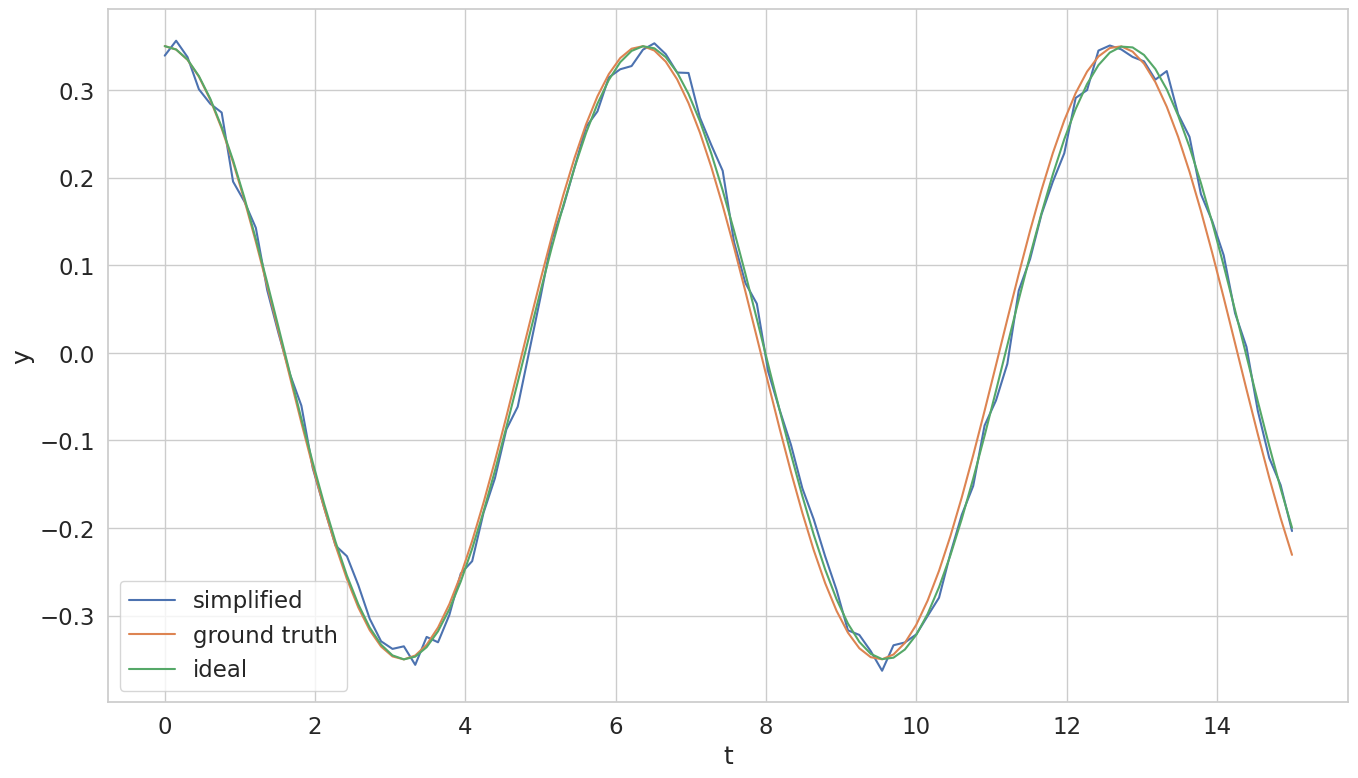

In [ ]:
show_data({"simplified": (ts, ys),
           "ground truth": (ts, ys_simple),
           "ideal": (ts, ys_best)})

Let's split our data into train and test, time-wise:

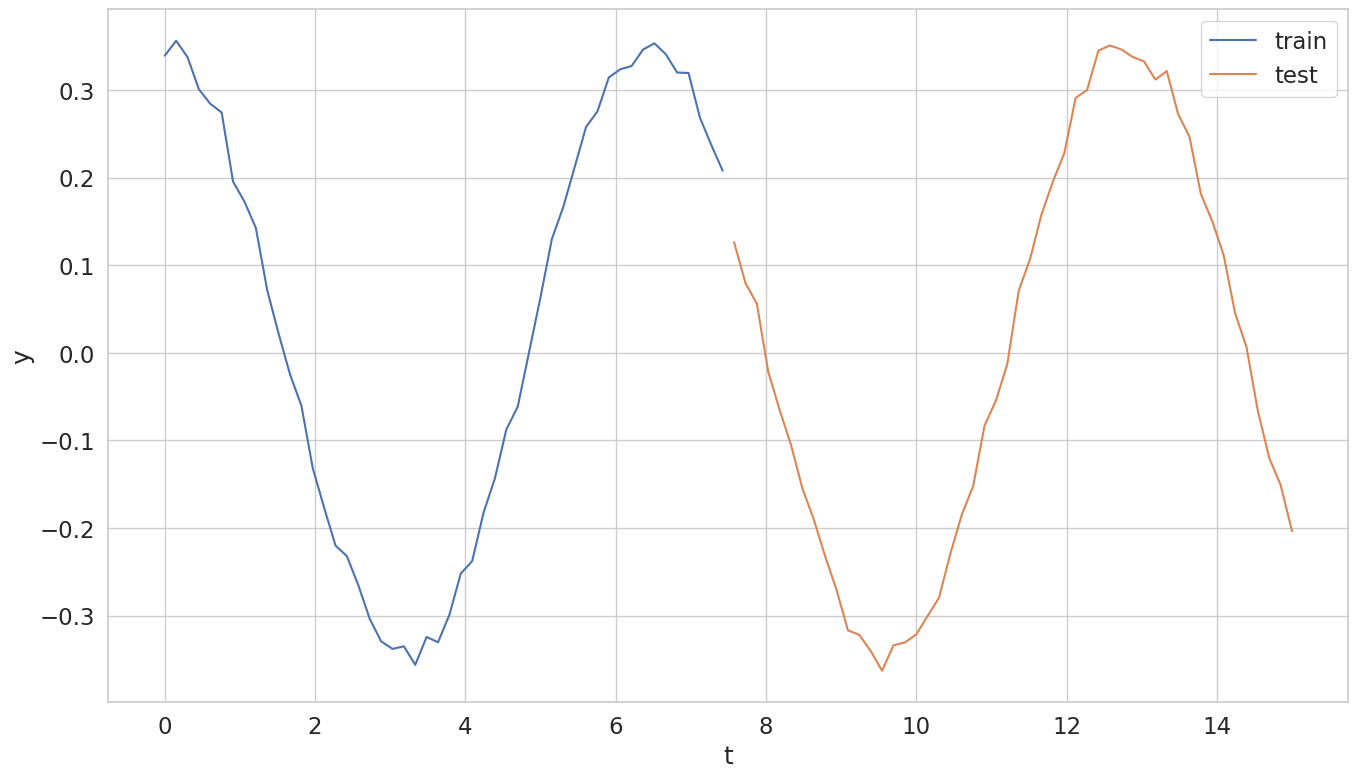

In [ ]:
train_frac = 0.5
train_size = int(len(ys) * train_frac)
ys_train = ys[:train_size]
ys_test = ys[train_size:]
ts_train = ts[:train_size]
ts_test = ts[train_size:]
show_data({
    "train": (ts_train, ys_train),
    "test": (ts_test, ys_test)
})

Next, we create a small neural network that will simulate this solution
$$
y = f(t)
$$

We will optimize it using MSE loss:
$$
MSE = \| y - \tilde{y} \|_2^2
$$

In [ ]:
class LinearBlock(nn.Module):
    """Linear layer + activation + initialization."""

    def __init__(self, ch_in: int, ch_out: int, final: bool = False) -> None:
        """Initialize LinearBlock.

        :param ch_in: number of input channels
        :param ch_out: number of output channels
        :param final: if True, do no add activation, if False, add tanh actiavtion
        """
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(ch_in, ch_out)
        if final:
            nn.init.xavier_normal_(self.fc.weight, gain=nn.init.calculate_gain("linear"))
            self.activation = None
        else:
            nn.init.xavier_normal_(self.fc.weight, gain=nn.init.calculate_gain("tanh"))
            self.activation = nn.Tanh()

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """Apply LinearBlock.

        :param t: input tensor, shape (batch_size, ch_in)
        :returns: output tensor, shape (batch_size, ch_out)
        """
        if self.activation is None:
            return self.fc(t)
        return self.activation(self.fc(t))

In [ ]:
class PendulumNet(nn.Module):
    """Simple fully-connected neural network."""

    def __init__(self, n_layers: int, size: int) -> None:
        """Initialize PendulumNet.

        :param n_layers: number of linear blocks (excluding first and last)
        :param size: number of hidden channels
        """
        super(PendulumNet, self).__init__()
        layers = [LinearBlock(1, size)]
        layers += [LinearBlock(size, size) for _ in range(n_layers)]
        layers += [LinearBlock(size, 1, final=True)]
        self.net = nn.Sequential(*layers)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """Apply PendulumNet.

        :param t: input time tensor, shape (batch_size, 1)
        :returns: output angle tensor, shape (batch_size, 1)
        """
        return self.net(t)

In [ ]:
net = PendulumNet(n_layers=3, size=32).float()
lossf = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)

In [ ]:
def train_step(
    model: PendulumNet,
    optimizer: Optimizer,
    loss_func: nn.Module,
    data_input: torch.Tensor,
    data_target: torch.Tensor,
) -> float:
    """Do one training epoch.

    :param model: PendulumNet instance
    :param optimizer: optimizer
    :param loss_func: loss_function
    :param data_input: input time tensor, shape (num_train_samples, 1)
    :param data_target: output angle tensor, shape (num_train_samples, 1)
    :returns: train loss at this epoch
    """
    model.train()
    optimizer.zero_grad()

    pred = model(data_input)
    loss = loss_func(pred, data_target)
    loss_value = loss.item()
    loss.backward()
    optimizer.step()
    return loss_value

def val_step(
    model: PendulumNet,
    loss_func: nn.Module,
    data_input: torch.Tensor,
    data_target: torch.Tensor,
) -> float:
    """Do one validation epoch.

    :param model: PendulumNet instance
    :param loss_func: loss_function
    :param data_input: input time tensor, shape (num_test_samples, 1)
    :param data_target: output angle tensor, shape (num_test_samples, 1)
    :returns: validation loss at this epoch
    """
    model.eval()
    pred = model(data_input)
    loss = loss_func(pred, data_target)
    loss_value = loss.item()
    return loss_value

def plot_learning_curve(train_losses: List[float], val_losses: List[float]) -> None:
    """Plot learning curve.

    :param train_losses: train losses
    :param val_losses: val losses
    """
    fig, ax = plt.subplots(figsize=(16,9))
    ax.semilogy(train_losses, label="train loss")
    ax.semilogy(val_losses, label="val loss")
    ax.legend();
    plt.show();
    plt.close();

In [ ]:
epochs = 5000

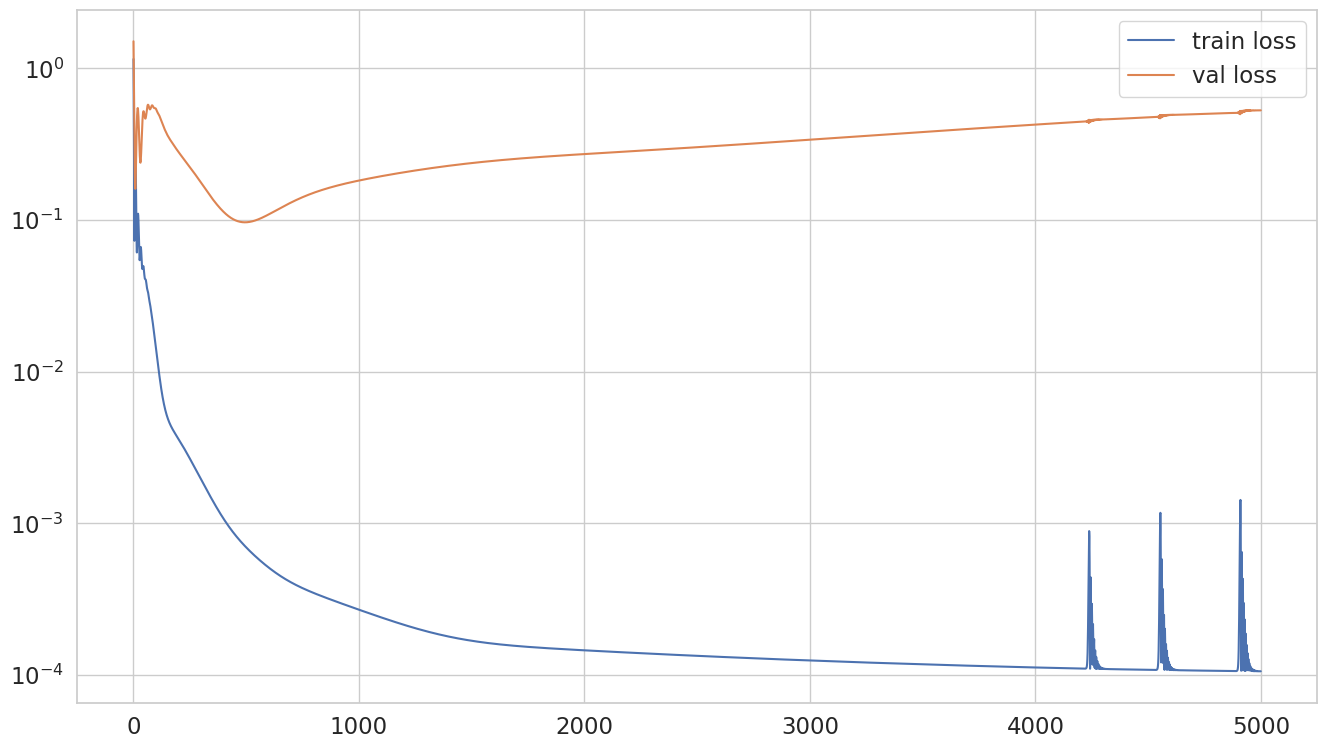

In [ ]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_step(
        model=net,
        optimizer=optim,
        loss_func=lossf,
        data_input=torch.from_numpy(ts_train).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_train).float().unsqueeze(1)
    )
    train_losses.append(train_loss)

    val_loss = val_step(
        model=net,
        loss_func=lossf,
        data_input=torch.from_numpy(ts_test).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_test).float().unsqueeze(1)
    )
    val_losses.append(val_loss)

plot_learning_curve(train_losses, val_losses)

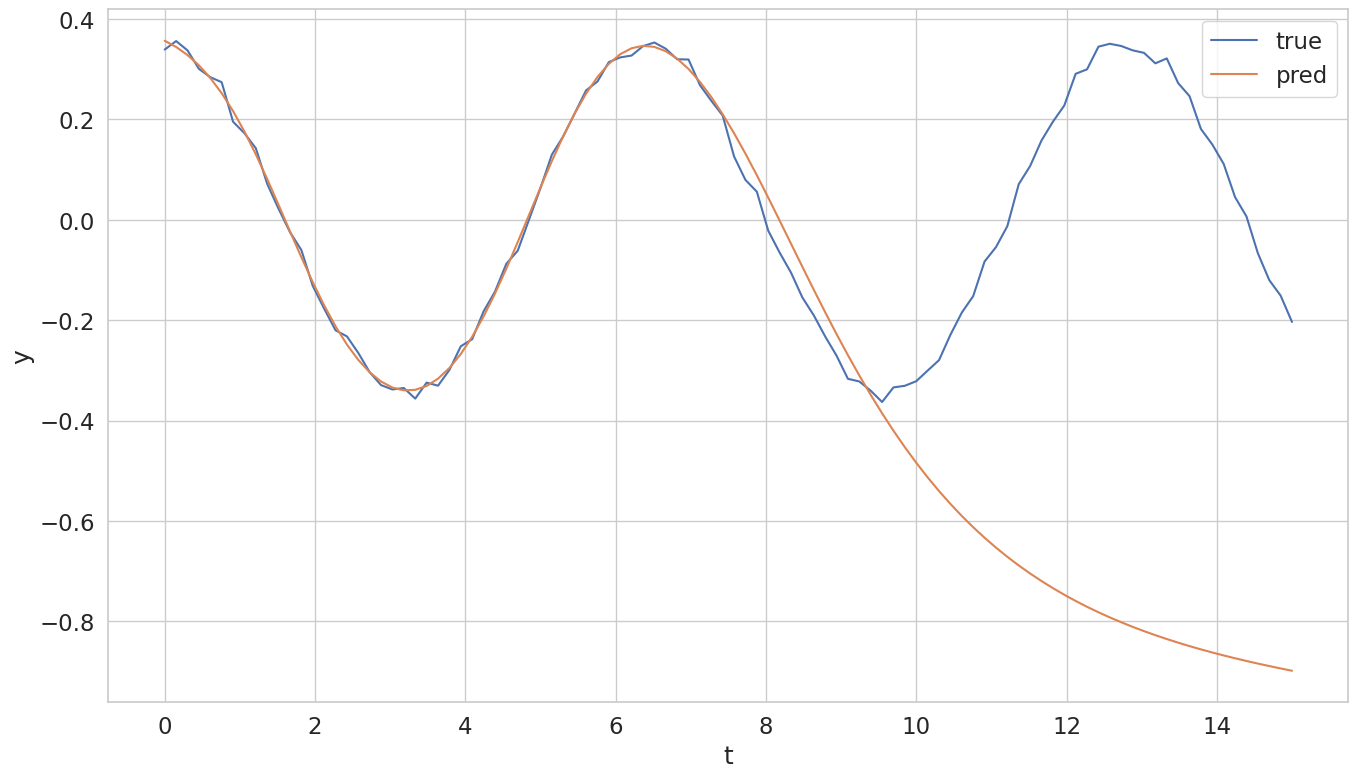

In [ ]:
pred_ys = net(torch.from_numpy(ts).float().unsqueeze(1)).data.numpy()
show_data({
    "true": (ts, ys),
    "pred": (ts, pred_ys)
})

We can see that our simple neural network fits the training dataset pretty well, but does not extrapolate to testing set.

## Physics-Informed Machine Learning

General machine learning in the supervised setting demonstrated before can work well enough in many cases, especially in the presence of large data samples. These data samples are usually produced with the use of physical models describing our knowledge of the data-generating process and its properties mathematically, as we saw in the pendulum example.

It turns out that we can leverage this knowledge to improve the training process.

## Incorporating physics via augmented loss function

There is a variety of ways to incorporate physical knowledge into machine learning training. Arguably, one of the most sucessful ways is to use an augmented loss function.

For example, a popular choice would be to match some statistics in predictions and ground truth. For example, these can be Fourier statistics, or any other statistic.

Let's denote the ground truth $u$, the prediction $\tilde{u}$, and the statistic $F$. Then one may consider the following loss augmentation:
$$
S = \|F(u) - F(\tilde{u}) \|_2^2
$$

Since our problem is purely mechanical, we will match mechanical statistics, such as first integrals. We know that simple pendulum has first integral of motion:
$$
W=\frac12 \left( \frac{\partial \theta}{\partial t}\right)^2 - \frac{g}{l} \cos \theta = \operatorname{const}
$$

Therefore, we can build the following loss augmentation:
$$
S = \left\| \left( \frac12 \left( \frac{\partial \theta}{\partial t}\right)^2 - \frac{g}{l} \cos \theta \right) - \hat W \right\|_2^2
$$

where $\hat W$ may be computed by two ways:
- by approximating on all the training dataset
- by approximating on the current batch

In our approach it's all the same as we use the whole train dataset as a batch

There is another step required to incorporate the PIML loss into our machine learning pipeline. It is to compute the derivatives. There are two ways on how one can obtain derivatives:
- Using finite differences on computational mesh
- Using pytorch autograd

Let's start with finite difference method. We can use finite difference approximation of the derivative:
$$
\frac{\partial y(t)}{\partial t} \approx \frac{y(t + h) - y(t)}{h}
$$

In [ ]:
def get_derivative(y: torch.Tensor, dt: float) -> torch.Tensor:
    """Compute 1st derivative using finite differences.

    For all elements apply forward scheme. The last element uses previous element as next

    :param y: angles tensor, shape (num_samples, 1)
    :param dt: time step
    :returns: derivatives tensor, shape (num_samples, 1)
    """
    # handle regular elements
    y_curr = y[:-1]
    y_next = y[1:]

    deriv = (y_next - y_curr)/dt

    # handle last element using copying
    deriv1 = deriv[-1].unsqueeze(dim=0)

    return torch.cat([deriv, deriv1], dim=0)

def physical_loss(y: torch.Tensor, yhat: torch.Tensor, dt: float) -> torch.Tensor:
    """Compare true and predicted first integral of pendulum using MSE.

    Compute true first integral, compute predicted first integral, compute MSE between them.

    :param y: true angles tensor, shape (num_samples, 1)
    :param yhat: predicted angles tensor, shape (num_samples, 1)
    :param dt: time step
    :returns: MSE, scalar tensor
    """
    dy_dt = get_derivative(y, dt)
    dyhat_dt = get_derivative(yhat, dt)
    # first integral error
    true_value = 0.5* dy_dt**2 - g/l * torch.cos(y)
    pred_value = 0.5* dyhat_dt**2 - g/l * torch.cos(yhat)
    error = true_value - pred_value
    return torch.mean(error ** 2)

Let's check how well our model represents first integral:

In [ ]:
pred_ys_train = net(torch.from_numpy(ts_train).float().unsqueeze(1)).data.numpy()

In [ ]:
physical_loss(
    torch.from_numpy(ys_train).float().unsqueeze(1),
    torch.from_numpy(pred_ys_train).float().unsqueeze(1),
    dt
).item()

0.0007699404959566891

Looks like our model caught the integral well enough. Let's see if training with this loss will improve the speed of convergence.

In [ ]:
net = PendulumNet(3, 32).float()
loss = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)

In [ ]:
phy_coef = 0.1
epochs = 5000

In [ ]:
def train_step_physical(
    model: PendulumNet,
    optimizer: Optimizer,
    loss_function: nn.Module,
    physical_loss_function: Callable,
    dt: Union[float, torch.Tensor],
    data_input: torch.Tensor,
    data_target: torch.Tensor,
) -> torch.Tensor:
    """Do one training epoch with physical loss.

    :param model: PendulumNet instance
    :param optimizer: optimizer
    :param loss_function: loss_function
    :param physical_loss_function: physical_loss_function
    :param dt: dt for finite differences
    :param data_input: input time tensor, shape (num_train_samples, 1)
    :param data_target: output angle tensor, shape (num_train_samples, 1)
    :returns: train loss at this epoch
    """
    model.train()
    optimizer.zero_grad()

    pred = model(data_input)
    loss1 = loss_function(pred, data_target)
    loss2 = physical_loss_function(data_target, pred, dt)

    loss = loss1 + phy_coef*loss2
    loss_value = loss.item()
    loss.backward()
    optimizer.step()
    return loss_value

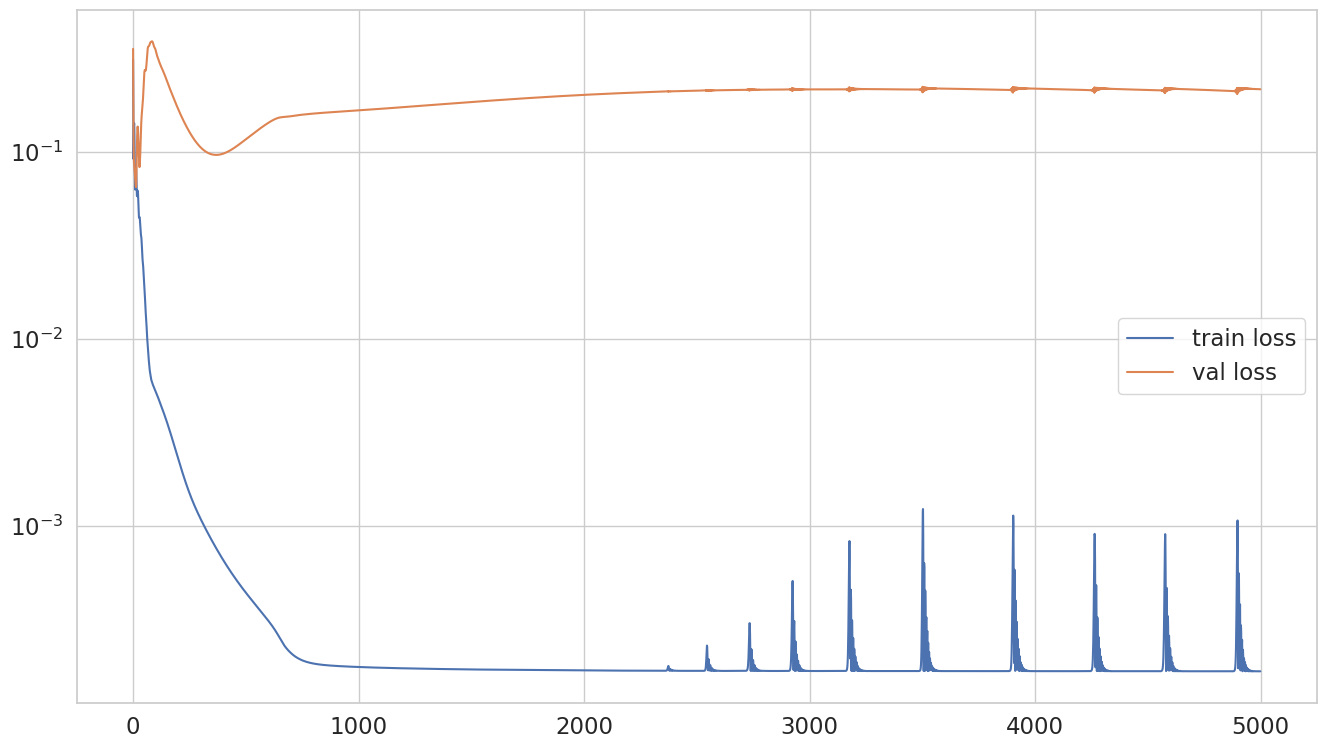

In [ ]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_step_physical(
        model=net,
        optimizer=optim,
        loss_function=lossf,
        physical_loss_function=physical_loss,
        dt=dt,
        data_input=torch.from_numpy(ts_train).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_train).float().unsqueeze(1)
    )
    train_losses.append(train_loss)

    val_loss = val_step(
        model=net,
        loss_func=lossf,
        data_input=torch.from_numpy(ts_test).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_test).float().unsqueeze(1),
    )
    val_losses.append(val_loss)

plot_learning_curve(train_losses, val_losses)

We can see a bit of decreasing overfitting, so at least it is working.

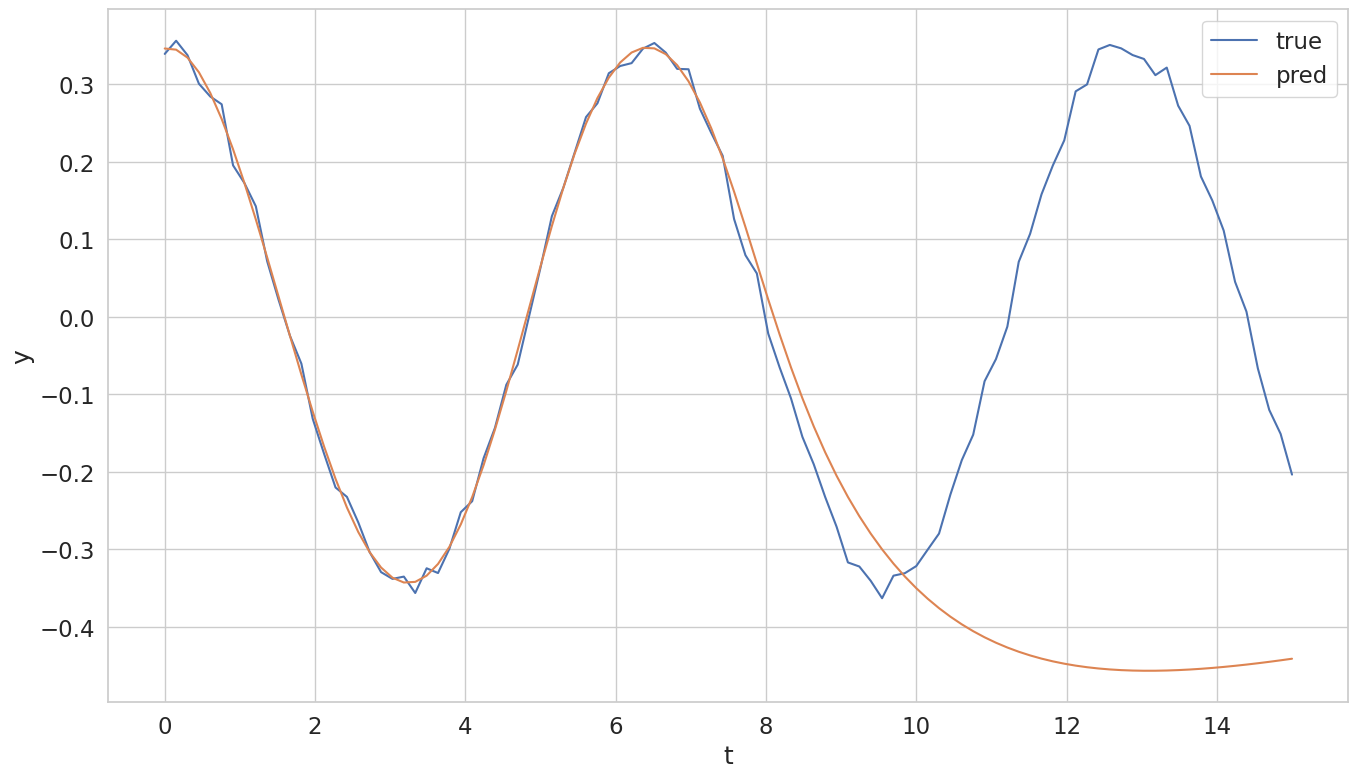

In [ ]:
pred_ys = net(torch.from_numpy(ts).float().unsqueeze(1)).data.numpy()
show_data({
    "true": (ts, ys),
    "pred": (ts, pred_ys)
})

We can see that still we do not have extrapolation to testing set (expectedly).

## Using other loss functions

In this section we will explore other choices of augmented loss function.

For example, consider a PDE:
$$
u_t = F(u, u_x, u_{xx}, \ldots)
$$

Let's say we are building a neural network to predict $u$. The prediction $\tilde{u}$ is likely to be imperfect, so we can define residual error:
$$
R = \| \tilde{u}_t - F(\tilde{u}, \tilde{u}_x, \tilde{u}_{xx}, \ldots) \|_2^2
$$

Note that this loss, in contrast to the previous one, does not require ground truth labels.

Then we can train our neural network to minimize this residual error in addition to the data loss. We can not usually train with residual error only, as many physical systems have non-unqiue solutions (i.e. $R = 0$ but $MSE \neq 0$).

For our toy problem with pendulum, we can write
$$
R = \| \frac{\partial^2 \tilde{y}}{\partial t^2} + \frac{g}{l} \sin \tilde{y} \|_2^2
$$

Let's again start with finite difference method. We can use finite difference approximation of second derivative:
$$
\frac{\partial^2 y(t)}{\partial t^2} \approx \frac{y(t + h) - 2y(t) + y(t - h)}{h^2}
$$
and its non-central variants.

In [ ]:
def get_second_derivatives(y: torch.Tensor, dt: float) -> torch.Tensor:
    """Compute 2nd derivatives using finite differences.

    For inner elements apply center scheme. For boundary (the first and last elements)
        use forward and backward schemes respectively.

    :param y: angles tensor, shape (num_samples, 1)
    :param dt: time step
    :returns: second derivatives tensor, shape (num_samples, 1)
    """
    # handle regular elements
    y_prev = y[:-2]
    y_curr = y[1:-1]
    y_next = y[2:]

    deriv = (y_prev - 2* y_curr + y_next) / dt ** 2

    # handle first element using second-order forward difference
    deriv0 = (2 * y[0] - 5 * y[1] + 4 * y[2] - y[3]) / dt ** 2

    # handle last element using second-order backward difference
    deriv1 = (2 * y[-1] - 5 * y[-2] + 4 * y[-3] - y[-4]) / dt ** 2

    return torch.cat([deriv0.unsqueeze(dim=0), deriv, deriv1.unsqueeze(dim=0)], dim=0)

def physical_loss(y: torch.Tensor, dt: float) -> torch.Tensor:
    """Compute the residual loss.

    Compute the residual using finite differences, compute MSE of it.

    :param y: true angles tensor, shape (num_samples, 1)
    :param dt: time step
    :returns: MSE of residual, scalar tensor
    """
    d2ydt2 = get_second_derivatives(y, dt)
    resid = d2ydt2 + torch.sin(y) * g/l
    return torch.mean(resid ** 2)

First, we need to remember that finite differences are just an approximation and therefore bear some error:

In [ ]:
print("Physical loss on noisy data:", physical_loss(torch.from_numpy(ys).float().unsqueeze(1), dt).item())
print("Physical loss on ideal data:", physical_loss(torch.from_numpy(ys_best).float().unsqueeze(1), dt).item())

Physical loss on noisy data: 1.5211502313613892
Physical loss on ideal data: 7.147320388867229e-07


Next let's see if our model reaches this error:

In [ ]:
physical_loss(net(torch.from_numpy(ts).float().unsqueeze(1)), dt).item()

0.055466603487730026

This means we can't improve our model by training with this loss. You can try it yourself, but we will perform a different experiment.

As you can see, computation of the residual loss does not require ground truth labels. This means that we can train in an unsupervised way using this loss! After such training, the predictions on test dataset will follow the correct physical equation. Coupled with the supervised training on train dataset, we expect the network to correctly extrapolate.

In [ ]:
net = PendulumNet(3, 32).float()
loss = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)

Sample time steps where physical equation constraints will be enforced:

In [ ]:
ts_phy = torch.linspace(-1.,1.,30).unsqueeze(1).requires_grad_(True)
dt_phy = (ts_phy[1] - ts_phy[0]).item() * t_scale

Introduce coefficient to balance data loss and physical loss

In [ ]:
phy_coef = 0.1
epochs = 10000

In [ ]:
def train_step_physical(
    model: PendulumNet,
    optimizer: Optimizer,
    loss_function: nn.Module,
    physical_loss_function: Callable,
    data_input: torch.Tensor,
    data_target: torch.Tensor,
    physical_input: torch.Tensor,
    dt: float,
) -> float:
    """Do one training epoch with physical loss.

    :param model: PendulumNet instance
    :param optimizer: optimizer
    :param loss_function: loss_function
    :param physical_loss_function: physical_loss_function
    :param data_input: input time tensor, shape (num_train_samples, 1)
    :param data_target: output angle tensor, shape (num_train_samples, 1)
    :param physical_input: input time tensor, shape (num_physical_samples, 1)
    :param dt: dt for finite differences
    :returns: train loss at this epoch
    """
    model.train()
    optimizer.zero_grad()

    pred = model(data_input)
    loss1 = loss_function(pred, data_target)

    pred2 = model(physical_input)
    loss2 = physical_loss_function(pred2, dt)

    loss = loss1 + phy_coef * loss2
    loss_value = loss.item()
    loss.backward()
    optimizer.step()
    return loss_value

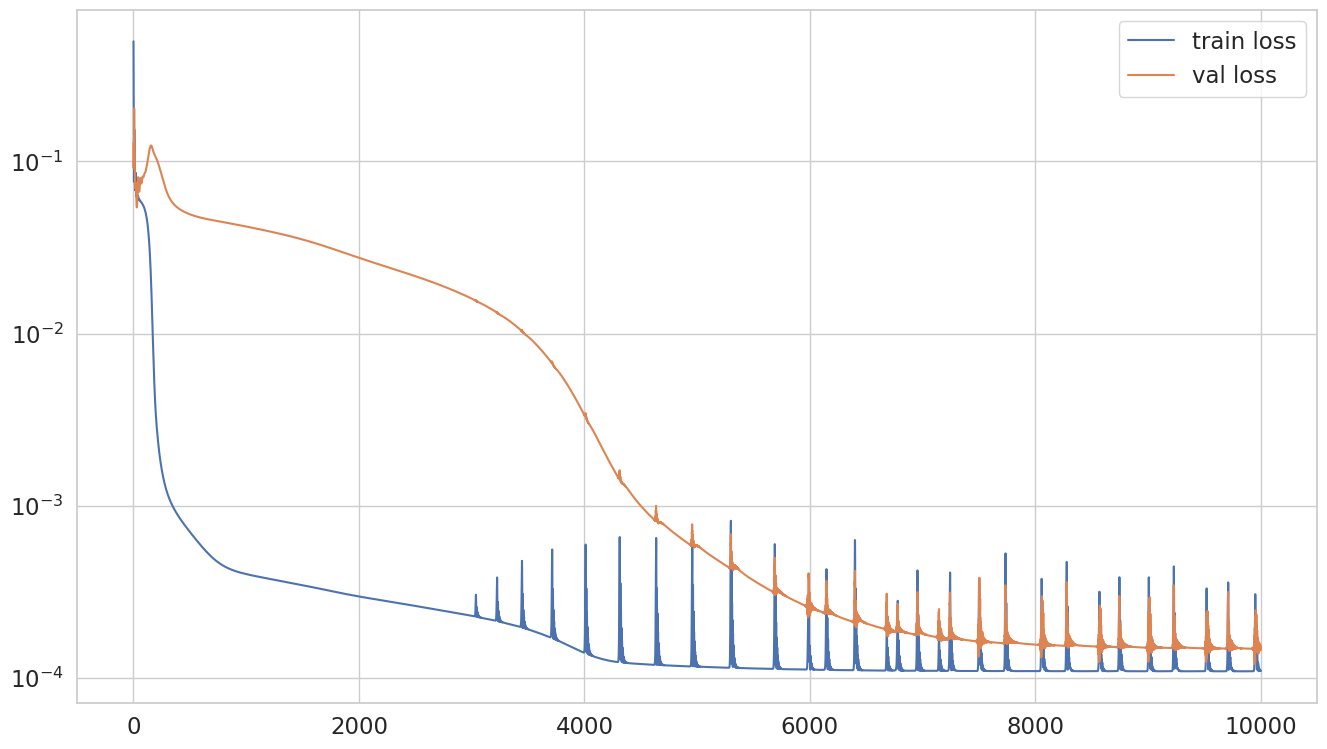

In [ ]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_step_physical(
        model=net,
        optimizer=optim,
        loss_function=lossf,
        physical_loss_function=physical_loss,
        data_input=torch.from_numpy(ts_train).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_train).float().unsqueeze(1),
        physical_input=ts_phy,
        dt=dt_phy
    )
    train_losses.append(train_loss)

    val_loss = val_step(
        model=net,
        loss_func=lossf,
        data_input=torch.from_numpy(ts_test).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_test).float().unsqueeze(1),
    )
    val_losses.append(val_loss)

plot_learning_curve(train_losses, val_losses)

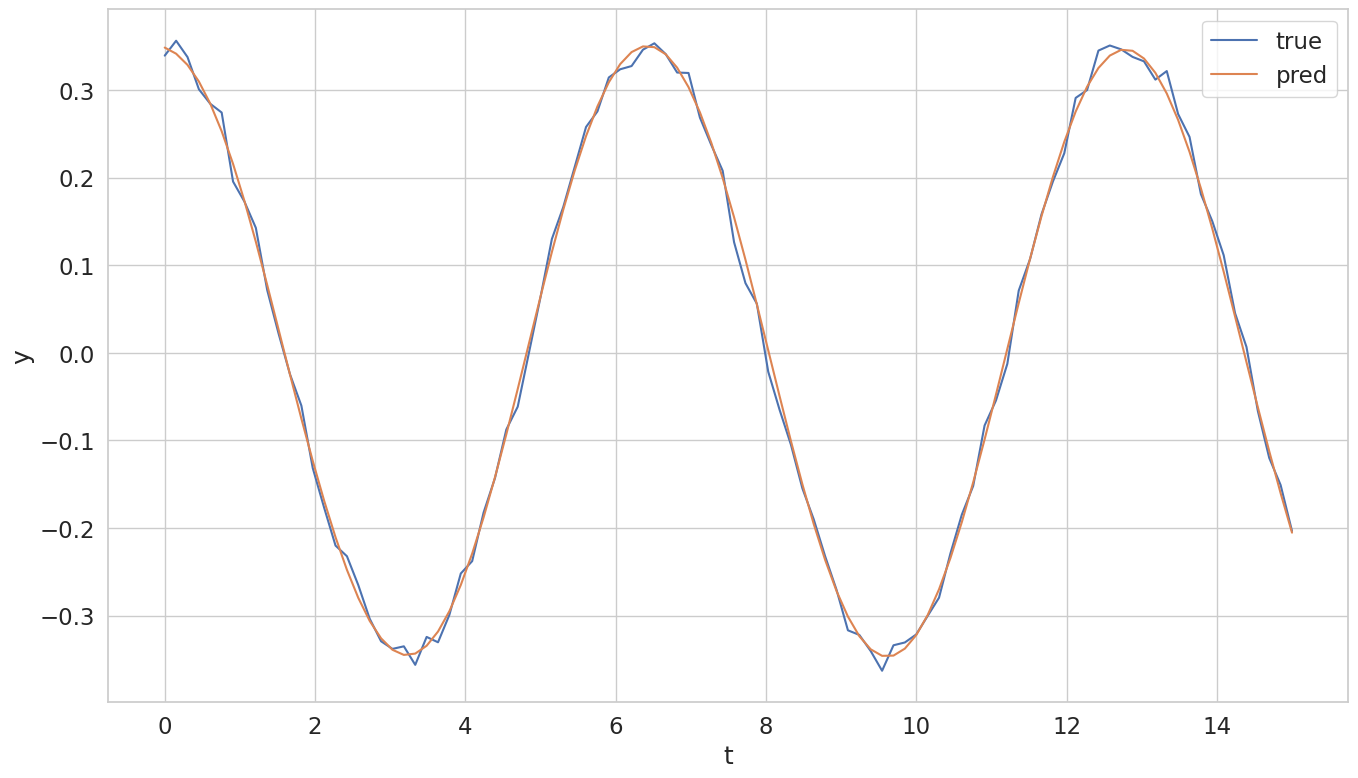

In [ ]:
pred_ys = net(torch.from_numpy(ts).float().unsqueeze(1)).data.numpy()
show_data({
    "true": (ts, ys),
    "pred": (ts, pred_ys)
})

As you can see, model becomes better, although the optimization has not converged. Next we will try using pytorch autograd derivatives.

## Using torch derivatives

In [ ]:
def get_derivatives_torch(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute derivatives using torch autograd.

    Note that y-tensor must be scalar and t-tensor must require grad and
        must be the exact one used in computation graph.

    :param y: angles tensor, scalar
    :param t: time tensor, shape (num_samples, 1)
    :returns: first derivatives tensor, shape (num_samples, 1)
    """
    return torch.autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]

def get_second_derivatives_torch(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute 2nd derivative using torch autograd.

    Note that y-tensor must be scalar and t-tensor must require grad and
        must be the exact one used in computation graph.

    :param y: angles tensor, scalar
    :param t: time tensor, shape (num_samples, 1)
    :returns: second derivatives tensor, shape (num_samples, 1)
    """
    yt = get_derivatives_torch(y, t)
    ytt = get_derivatives_torch(yt, t)
    return ytt

def physical_loss_torch(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the residual loss.

    Compute the residual using torch autograd, compute MSE of it.

    :param y: true angles tensor, shape (num_samples, 1)
    :param t: time tensor, shape (num_samples, 1)
    :returns: MSE of residual, scalar tensor
    """
    d2ydt2 = get_second_derivatives_torch(y.sum(), t) / t_scale**2
    resid = d2ydt2 + torch.sin(y) * g/l
    return torch.mean(resid ** 2)

In [ ]:
net = PendulumNet(3, 32).float()
lossf = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)

In [ ]:
phy_coef = 1.
epochs = 10000


In [ ]:
ts_phy = torch.linspace(-1.,1.,30).unsqueeze(1).requires_grad_(True)

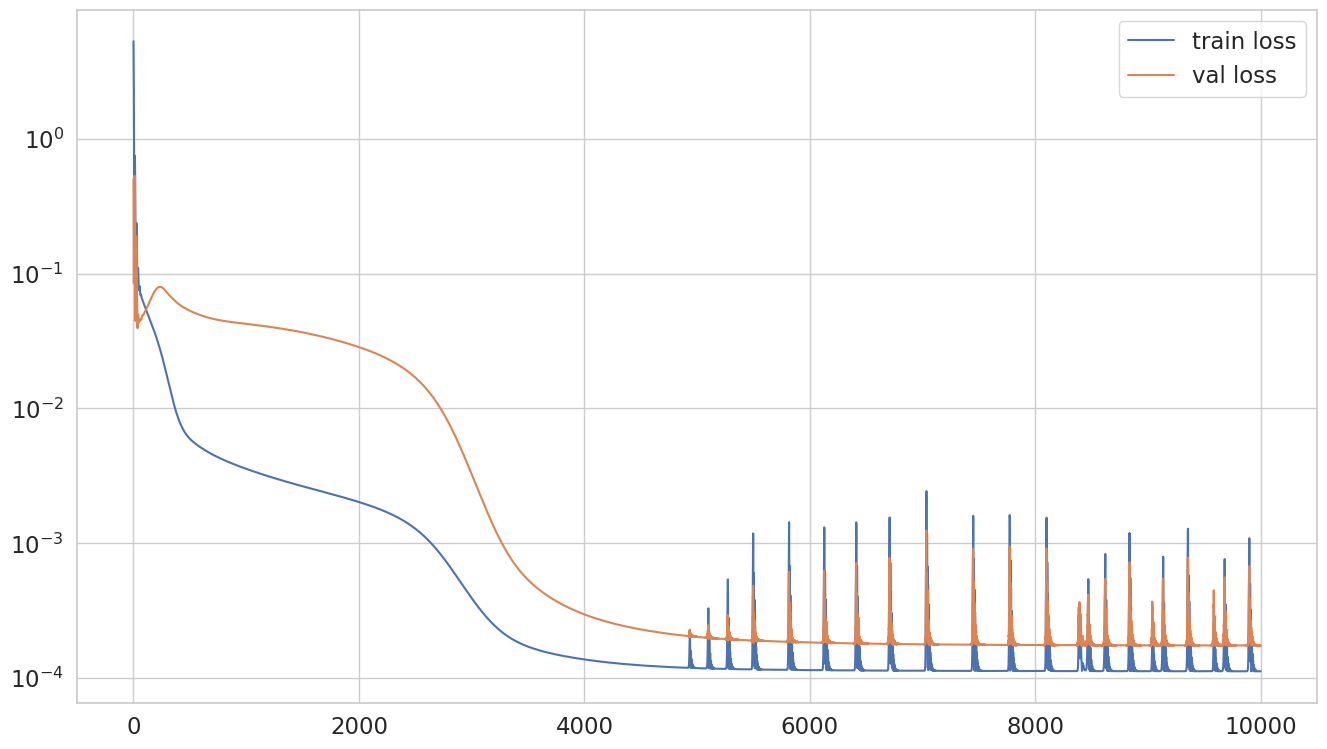

In [ ]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    loss_value = train_step_physical(
        model=net,
        optimizer=optim,
        loss_function=lossf,
        physical_loss_function=physical_loss_torch,
        data_input=torch.from_numpy(ts_train).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_train).float().unsqueeze(1),
        physical_input=ts_phy,
        dt=ts_phy
    )
    train_losses.append(loss_value)

    val_loss = val_step(
        model=net,
        loss_func=lossf,
        data_input=torch.from_numpy(ts_test).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_test).float().unsqueeze(1),
    )
    val_losses.append(val_loss)

plot_learning_curve(train_losses, val_losses)

In [ ]:
pred_ys_precise = net(torch.from_numpy(ts).float().unsqueeze(1)).data.numpy()

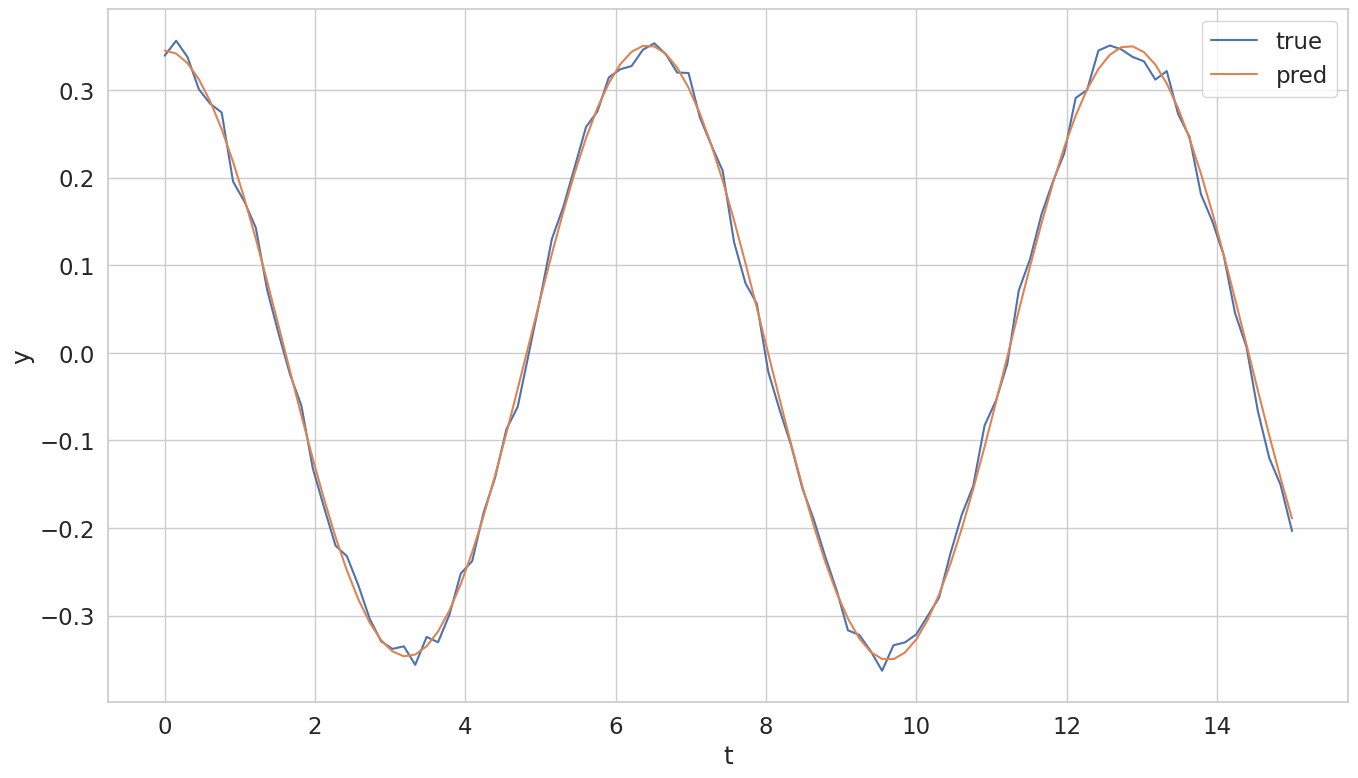

In [ ]:
show_data({
    "true": (ts, ys),
    "pred": (ts, pred_ys_precise)
})

One can observe that it solved the problem with numerical errors and worked perfectly well for denoising the measurements. Now let's see how it works for the unprecise physics setting

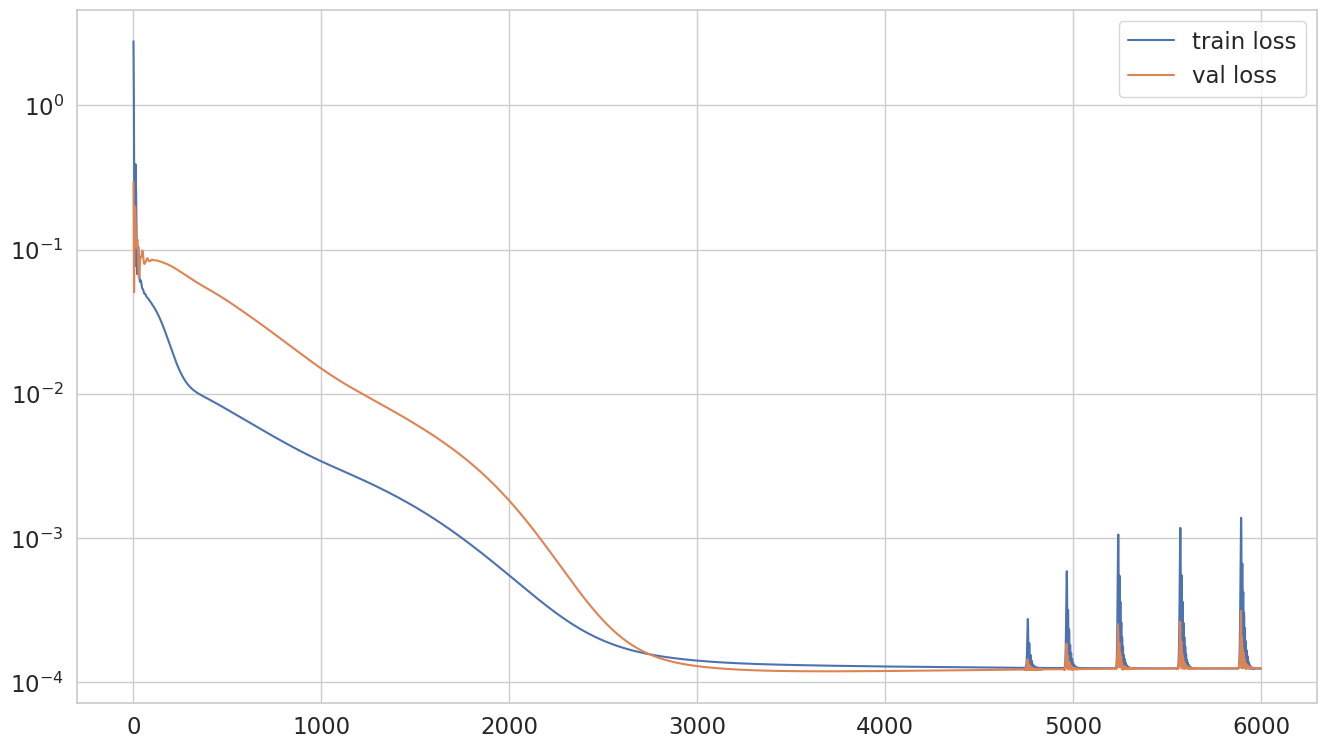

In [ ]:
def physical_loss_torch(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the residual loss.

    Compute the residual using torch autograd, compute MSE of it.

    :param y: true angles tensor, shape (num_samples, 1)
    :param t: time tensor, shape (num_samples, 1)
    :returns: MSE of residual, scalar tensor
    """
    d2ydt2 = get_second_derivatives_torch(y.sum(), t) / t_scale**2
    resid = d2ydt2 + y * g/l
    return torch.mean(resid ** 2)

net = PendulumNet(3, 32).float()
lossf = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)
phy_coef = 1.
epochs = 6000
ts_phy = torch.linspace(-1.,1.,30).unsqueeze(1).requires_grad_(True)

train_losses = []
val_losses = []
for epoch in range(epochs):
    loss_value = train_step_physical(
        model=net,
        optimizer=optim,
        loss_function=lossf,
        physical_loss_function=physical_loss_torch,
        data_input=torch.from_numpy(ts_train).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_train).float().unsqueeze(1),
        physical_input=ts_phy,
        dt=ts_phy
    )
    train_losses.append(loss_value)

    val_loss = val_step(
        model=net,
        loss_func=lossf,
        data_input=torch.from_numpy(ts_test).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_test).float().unsqueeze(1),
    )
    val_losses.append(val_loss)

plot_learning_curve(train_losses, val_losses)

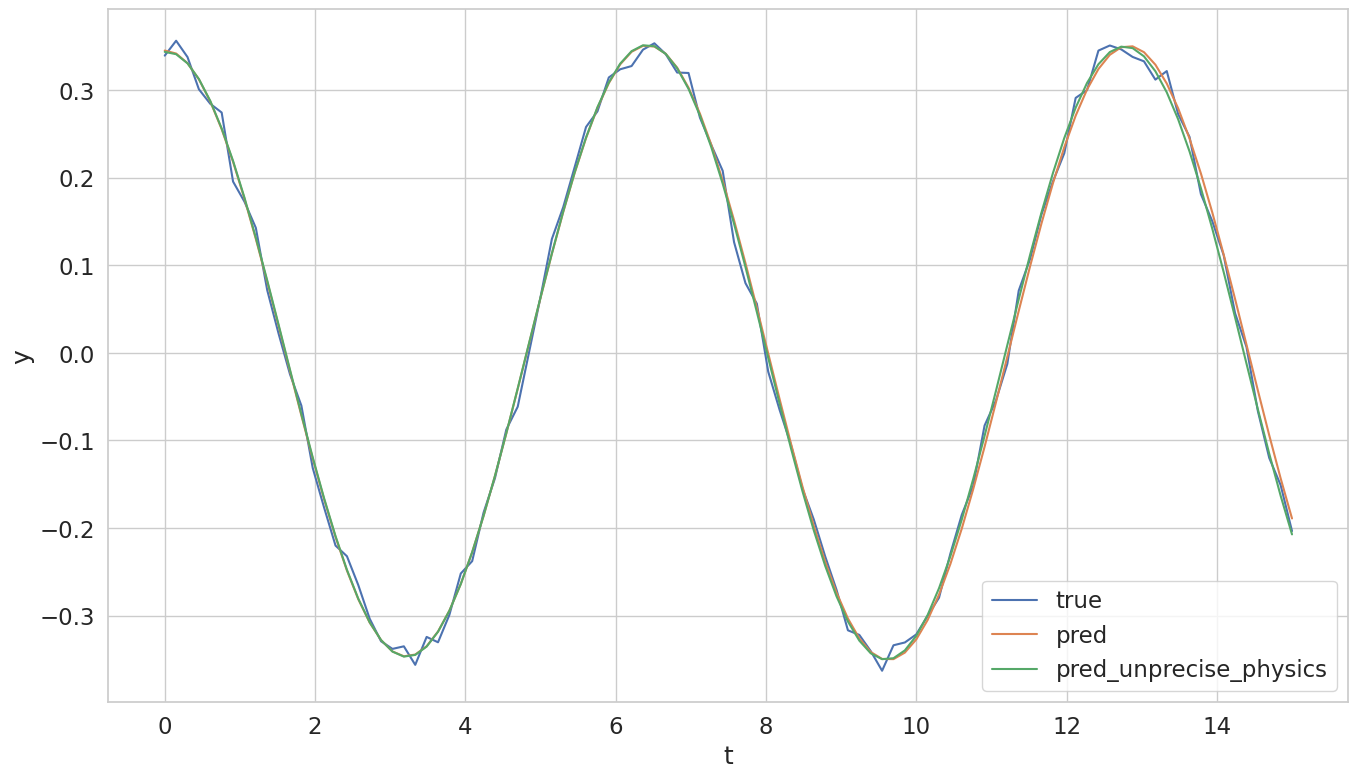

In [ ]:
pred_ys_unprecise = net(torch.from_numpy(ts).float().unsqueeze(1)).data.numpy()

show_data({
    "true": (ts, ys),
    "pred": (ts, pred_ys_precise),
    "pred_unprecise_physics": (ts, pred_ys_unprecise)
})

Even from unprecise physics we captured right prediction using the data!

The last experiment - can we learn by using no data?

Streaming output truncated to the last 5000 lines.
7500
tensor(1.9436e-06, grad_fn=<MeanBackward0>) tensor(3.0094e-06, grad_fn=<MeanBackward0>)
7501
tensor(1.8742e-06, grad_fn=<MeanBackward0>) tensor(1.4888e-06, grad_fn=<MeanBackward0>)
7502
tensor(2.4709e-06, grad_fn=<MeanBackward0>) tensor(1.6345e-08, grad_fn=<MeanBackward0>)
7503
tensor(2.5892e-06, grad_fn=<MeanBackward0>) tensor(9.0217e-07, grad_fn=<MeanBackward0>)
7504
tensor(2.2844e-06, grad_fn=<MeanBackward0>) tensor(2.4948e-06, grad_fn=<MeanBackward0>)
7505
tensor(1.9240e-06, grad_fn=<MeanBackward0>) tensor(2.0642e-06, grad_fn=<MeanBackward0>)
7506
tensor(1.6338e-06, grad_fn=<MeanBackward0>) tensor(4.7266e-07, grad_fn=<MeanBackward0>)
7507
tensor(1.7661e-06, grad_fn=<MeanBackward0>) tensor(1.0948e-07, grad_fn=<MeanBackward0>)
7508
tensor(2.0167e-06, grad_fn=<MeanBackward0>) tensor(1.1834e-06, grad_fn=<MeanBackward0>)
7509
tensor(2.1249e-06, grad_fn=<MeanBackward0>) tensor(1.7797e-06, grad_fn=<MeanBackward0>)
7510
tensor(2.0503e

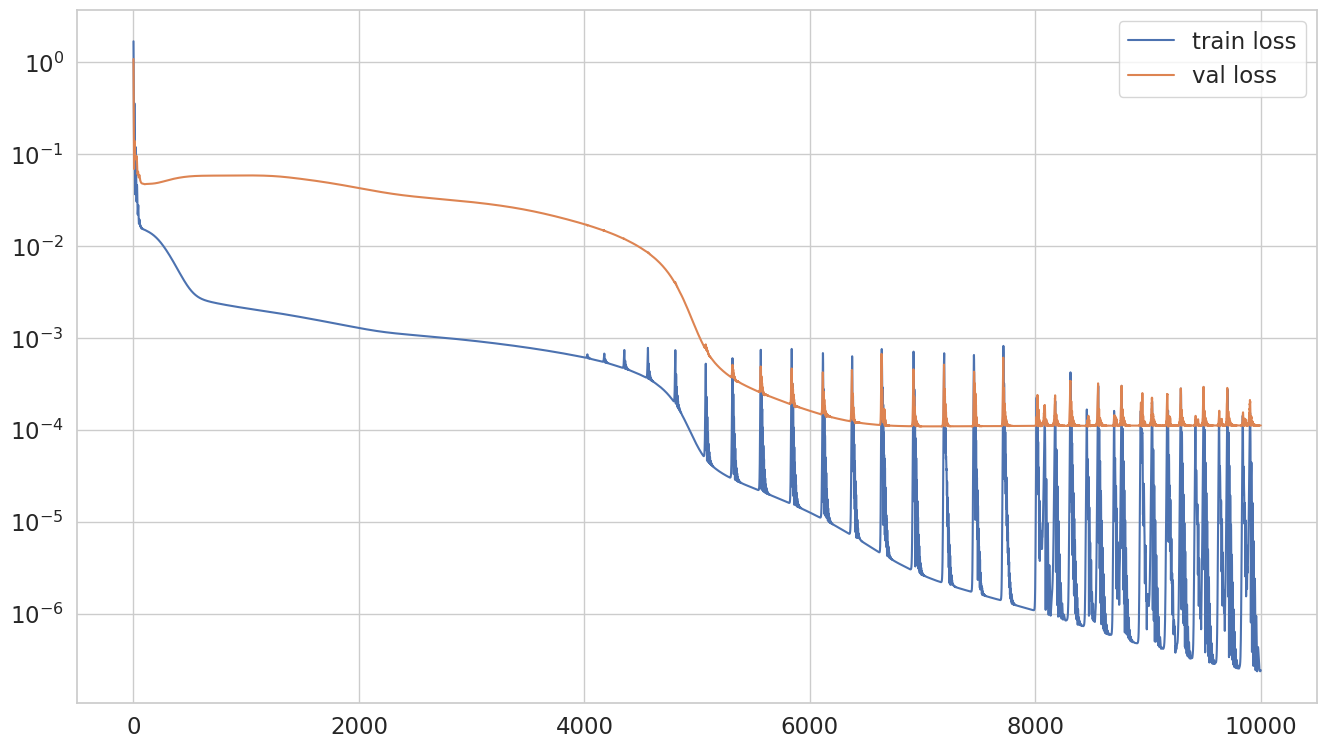

In [ ]:
def physical_loss_torch(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the residual loss.

    Compute the residual using torch autograd, compute MSE of it.

    :param y: true angles tensor, shape (num_samples, 1)
    :param t: time tensor, shape (num_samples, 1)
    :returns: MSE of residual, scalar tensor
    """
    d2ydt2 = get_second_derivatives_torch(y.sum(), t) / t_scale**2
    resid = d2ydt2 + torch.sin(y) * g/l

    # Initial condition on first derivative
    first_derivative = get_derivatives_torch(y.sum(), t) / t_scale
    first_derivative_res = first_derivative[0]
    print(torch.mean(resid**2), torch.mean(first_derivative_res**2))
    return torch.mean(resid ** 2 + first_derivative_res ** 2)

net = PendulumNet(3, 32).float()
lossf = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)
phy_coef = 1.
epochs = 10000
ts_phy = torch.linspace(-1.,1.,30).unsqueeze(1).requires_grad_(True)

train_losses = []
val_losses = []
for epoch in range(epochs):
    print(epoch)
    loss_value = train_step_physical(
        model=net,
        optimizer=optim,
        loss_function=lossf,
        physical_loss_function=physical_loss_torch,
        data_input=torch.from_numpy(np.zeros((1,1))-1.).float().unsqueeze(1),
        data_target=torch.from_numpy(np.zeros((1,1))+y_0).float().unsqueeze(1),
        physical_input=ts_phy,
        dt=ts_phy
    )
    train_losses.append(loss_value)

    val_loss = val_step(
        model=net,
        loss_func=lossf,
        data_input=torch.from_numpy(ts_test).float().unsqueeze(1),
        data_target=torch.from_numpy(ys_test).float().unsqueeze(1),
    )
    val_losses.append(val_loss)

plot_learning_curve(train_losses, val_losses)

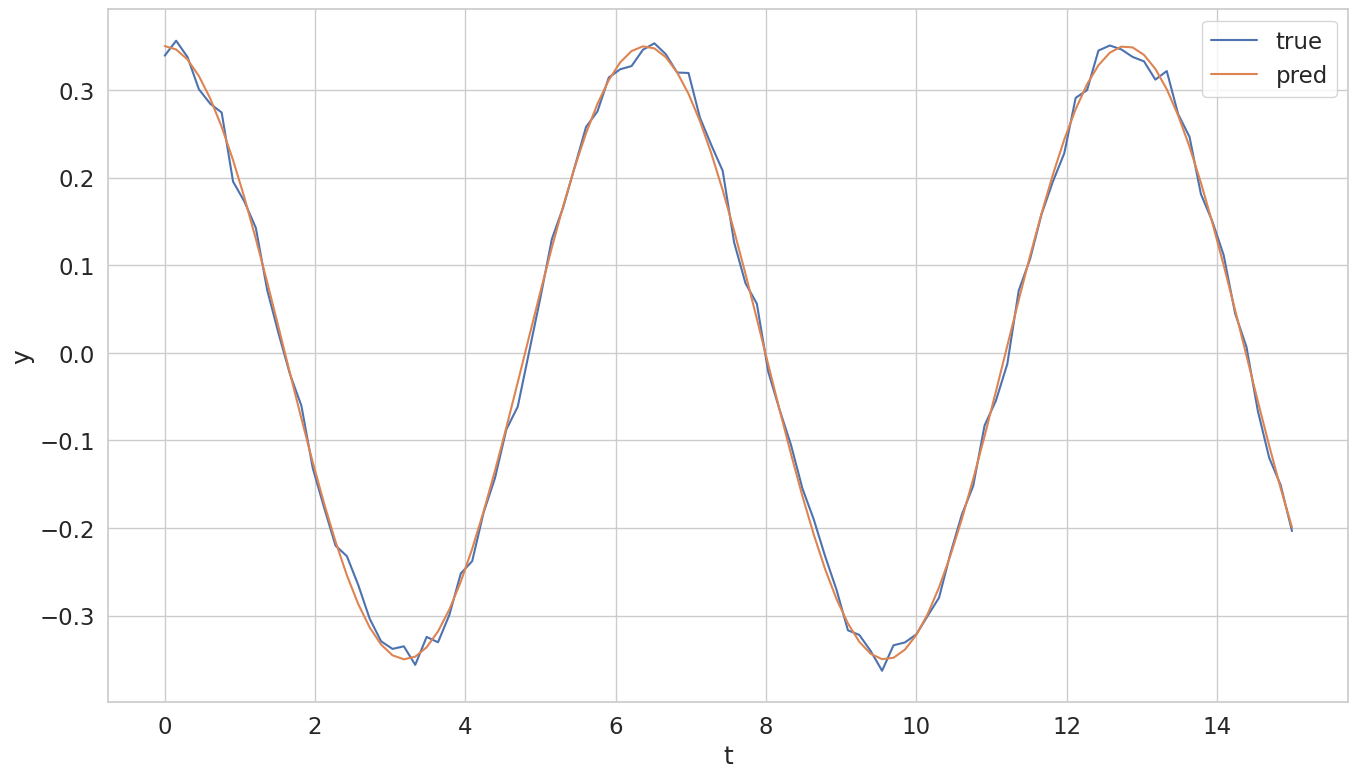

In [ ]:
pred = net(torch.from_numpy(ts).float().unsqueeze(1)).data.numpy()

show_data({
    "true": (ts, ys),
    "pred": (ts, pred),
})

It worked, even if slowly!

## Problem 2: Burgers equation

As a next step we'll do the same with a PDE. For this purpose, we chose 1D Burgers equation, which is very simple but non-linear:
$$
\frac{\partial u}{\partial t} + u \nabla u = \nu \nabla \cdot \nabla u
$$

Let's now define a solution on a periodic domain $[-1, 1]$ discretized to 128 cells, over time interval of 1 discretized to 32 time steps. We will impose Dirichlet boundary conditions $u = 0$ and initial state $-\sin \pi x$. The solution is pre-computed for your convenience.

In [ ]:
n = 128
dx = 2 / n
steps = 32
dt = 1 / steps
nu = 0.01 / np.pi

In [ ]:
!wget https://raw.githubusercontent.com/Vovcick/SciML-sem/main/burgers_solution.npz

--2025-10-09 10:28:59--  https://raw.githubusercontent.com/Vovcick/SciML-sem/main/burgers_solution.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17160 (17K) [application/octet-stream]
Saving to: ‘burgers_solution.npz.1’

burgers_solution.np 100%[===================>]  16.76K  --.-KB/s    in 0.001s  

2025-10-09 10:28:59 (11.4 MB/s) - ‘burgers_solution.npz.1’ saved [17160/17160]



In [ ]:
vels = np.load("burgers_solution.npz")["arr_0"]

In [ ]:
colors = sns.color_palette("flare", n_colors=steps)
cmap = sns.color_palette("flare", n_colors=steps, as_cmap=True)

In [ ]:
from matplotlib import cm as cm

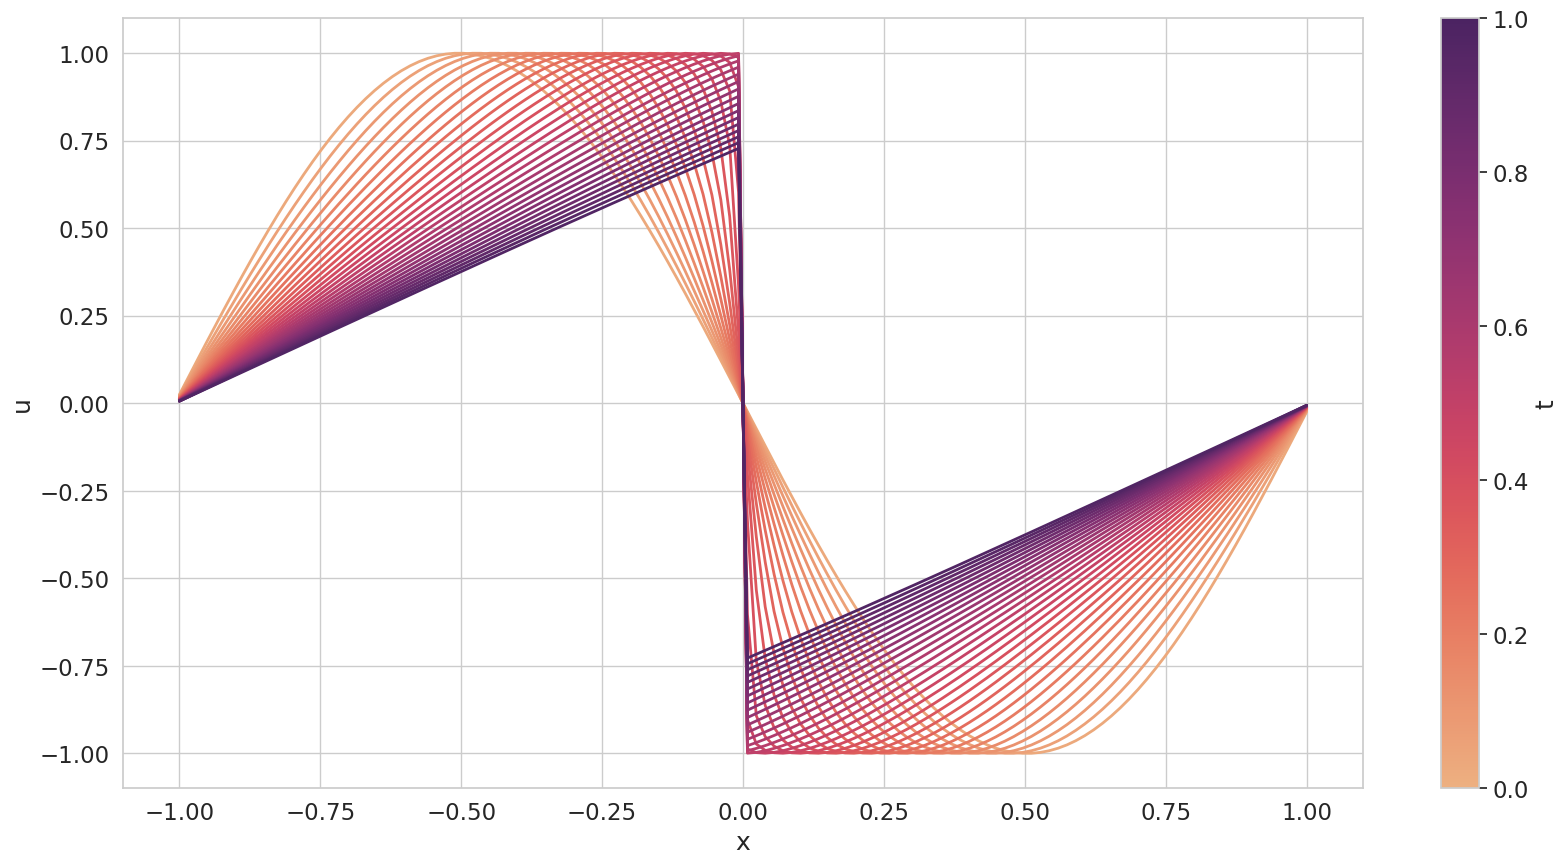

In [ ]:
def show_burgers_ux(u: np.ndarray) -> None:
    """Plot solution of Burgers equation in (u, x) coordinates.

    :param u: solution
    """
    fig,ax = plt.subplots(figsize=(20,10))
    for i, (state, c) in enumerate(zip(u.T, colors)):
        ax.plot(np.linspace(-1,1,n), state, lw=2, c=c)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=ax)
    cbar.set_label(label='t')
    plt.show()
    plt.close()
show_burgers_ux(vels)

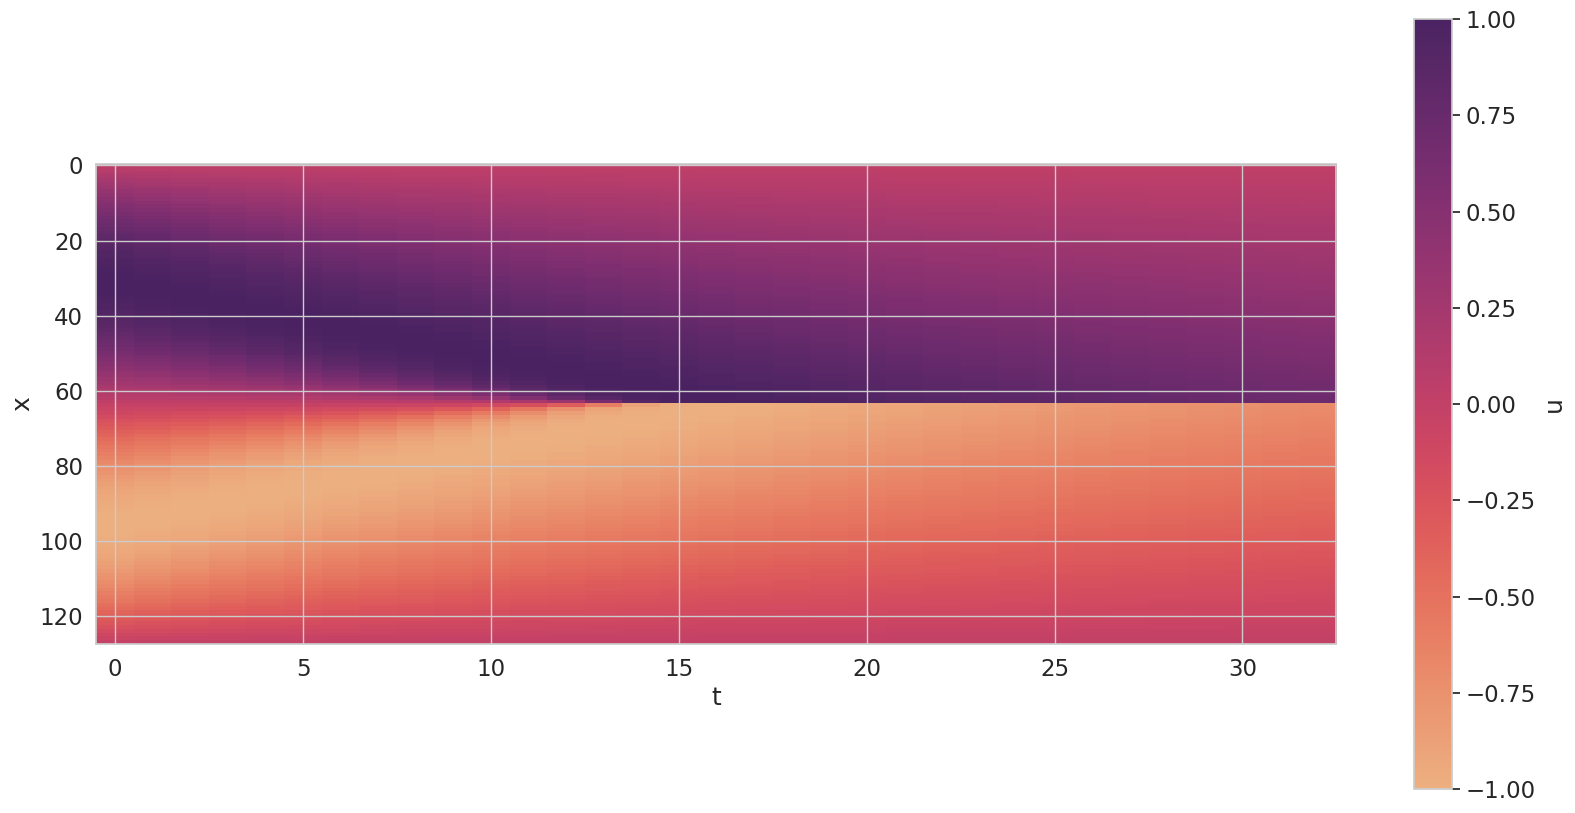

In [ ]:
def show_burgers_xt(u: np.ndarray) -> None:
    """Plot solution of Burgers equation in (x, t) coordinates.

    :param u: solution
    """
    fig, ax = plt.subplots(figsize=(20,10))
    im = ax.imshow(u, aspect=0.1, cmap="flare", vmin=-1, vmax=1)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    cbar = plt.colorbar(im)
    cbar.set_label(label='u')
    plt.show()
    plt.close()
show_burgers_xt(vels)

In [ ]:
def show_burgers_xu(us: List[np.ndarray], labels: List[str], title: str) -> None:
    """Plot solution of Burgers equation in (x, u) coordinates.

    :param us: list of solutions at several time steps
    :param labels: labels for time steps
    :param title: plot title
    """
    fig, ax = plt.subplots(figsize=(20,10))
    for i, (state, label) in enumerate(zip(us, labels)):
        ax.plot(np.linspace(-1,1,n), state, lw=2, c=f'C{i}', label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.set_title(title)
    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=ax)
    cbar.set_label(label='t')
    plt.show()
    plt.close()

Let's define a small neural network that will simulate this solution
$$
u = f(t, x)
$$

In [ ]:
class BurgersNet(nn.Module):
    """Simple fully-connected neural network."""

    def __init__(self, n_layers: int, size: int) -> None:
        """Initialize BurgersNet.

        :param n_layers: number of linear blocks (excluding first and last)
        :param size: number of hidden channels
        """
        super(BurgersNet, self).__init__()
        layers = [LinearBlock(2, size)]
        layers += [LinearBlock(size, size) for _ in range(n_layers)]
        layers += [LinearBlock(size, 1, final=True)]
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """Apply BurgersNet.

        :param x: input space tensor, shape (batch_size, 1)
        :param t: input time tensor, shape (batch_size, 1)
        :returns: output velocity tensor, shape (batch_size, 1)
        """
        xt = torch.stack([x, t], dim=-1)
        return self.net(xt)

In [ ]:
def eval_net(net: nn.Module, u: np.ndarray) -> np.ndarray:
    """Evaluate the solution obtained with BurgersNet.

    :param net: BurgersNet
    :param u: true solution
    :returns: predicted solution
    """
    grid_x, grid_t = np.meshgrid(np.linspace(-1, 1, n), np.linspace(0, 1, steps+1), indexing='ij')
    grid_u = net(
        torch.from_numpy(grid_x).float().flatten(),
        torch.from_numpy(grid_t).float().flatten(),
    ).data.numpy().reshape((n, steps+1))
    show_burgers_xt(grid_u)
    show_burgers_xu([grid_u[:, 0], u[:, 0]], ["predicted", "true"], f"Prediction at t=0")
    show_burgers_xu([grid_u[:, 16], u[:, 16]], ["predicted", "true"], f"Prediction at t=1/2")
    return grid_u

We will optimize our network using MSE loss:
$$
MSE = \| u - \tilde{u} \|_2^2
$$

We will use the solution at some first time steps and the boundary conditions as ground truth:

In [ ]:
def boundary_x_cond(num_points: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Zero boundary condition.

    :param num_points: number of points to include in boundary condition
    :returns:
        - space tensor, shape (num_points,)
        - time tensor, shape (num_points,)
        - velocity tensor, shape (num_points,)
    """
    t = torch.rand(num_points)
    x1 = torch.ones(t.shape[0] // 2, dtype=t.dtype, device=t.device)
    x2 = - torch.ones(t.shape[0] // 2, dtype=t.dtype, device=t.device)
    x = torch.cat([x1, x2], dim=0)
    u = torch.zeros_like(t)
    return x, t, u

def boundary_t_cond(i_range: List[int]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Initial condition.

    :param i_range: time steps to include in initial condition
    :returns:
        - space tensor, shape (len(i_range) * n,)
        - time tensor, shape (len(i_range) * n,)
        - velocity tensor, shape (len(i_range) * n,)
    """
    x0 = torch.linspace(-1, 1, n)
    x = torch.tile(x0, (len(i_range),))
    u = torch.from_numpy(vels[:, i_range].T).flatten()
    t = torch.cat([i / 32 * torch.ones_like(x0) for i in i_range], dim=0)
    return x, t, u

def ground_truth(
    num_points: int,
    i_range: List[int] = (0, 6, 12)
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Initial and boundary conditions.

    :param num_points: number of points to include in boundary condition
    :param i_range: time steps to include in initial condition
    :returns:
        - space tensor, shape (len(i_range) * n + num_points,)
        - time tensor, shape (len(i_range) * n + num_points,)
        - velocity tensor, shape (len(i_range) * n + num_points,)
    """
    x_b, t_b, u_b = boundary_x_cond(num_points)
    x_0, t_0, u_0 = boundary_t_cond(i_range)
    x = torch.cat([x_b, x_0], dim=0)
    t = torch.cat([t_b, t_0], dim=0)
    u = torch.cat([u_b, u_0], dim=0)
    return x, t, u

Let's try it out

In [ ]:
net = BurgersNet(8, 32).float()
lossf = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)

In [ ]:
epochs = 10000
num_points = 100

In [ ]:
def training_step(model: BurgersNet, optimizer: Optimizer, loss_function: nn.Module, num_points: int) -> float:
    """Do one training epoch.

    :param model: BurgersNet instance
    :param optimizer: optimizer
    :param loss_function: loss_function
    :param num_points: number of points for initial condition
    :returns: train loss at this epoch
    """
    model.train()
    optimizer.zero_grad()

    x, t, u = ground_truth(num_points)
    uh = model(x, t).squeeze()

    loss = loss_function(uh, u)
    loss_value = loss.item()
    loss.backward()
    optimizer.step()
    return loss_value

def plot_learning_curve(train_losses: List[float]) -> None:
    """Plot learning curve.

    :param train_losses: train losses
    """
    fig, ax = plt.subplots(figsize=(16,9))
    ax.semilogy(train_losses, label="train loss")
    ax.legend();
    plt.show();
    plt.close();

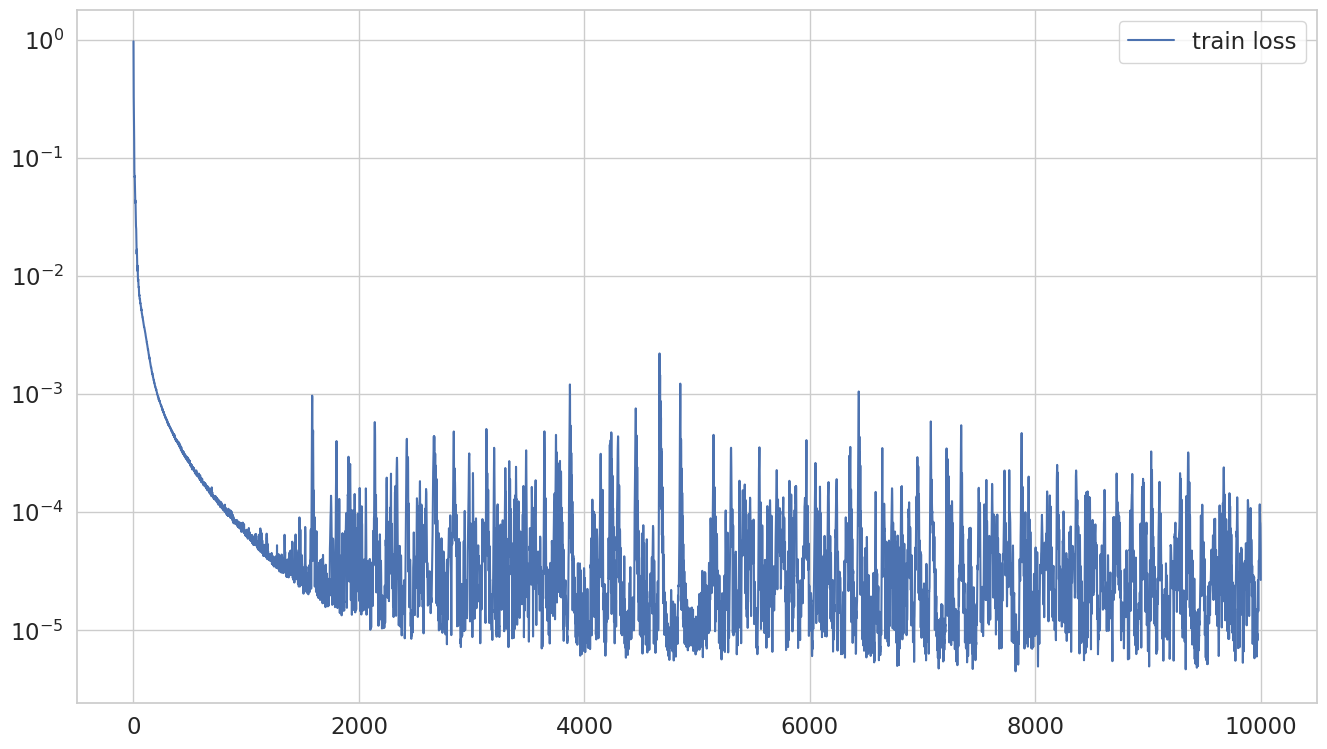

In [ ]:
train_losses = []
for epoch in range(epochs):
    train_loss = training_step(net, optim, lossf, num_points)
    train_losses.append(train_loss)
plot_learning_curve(train_losses)

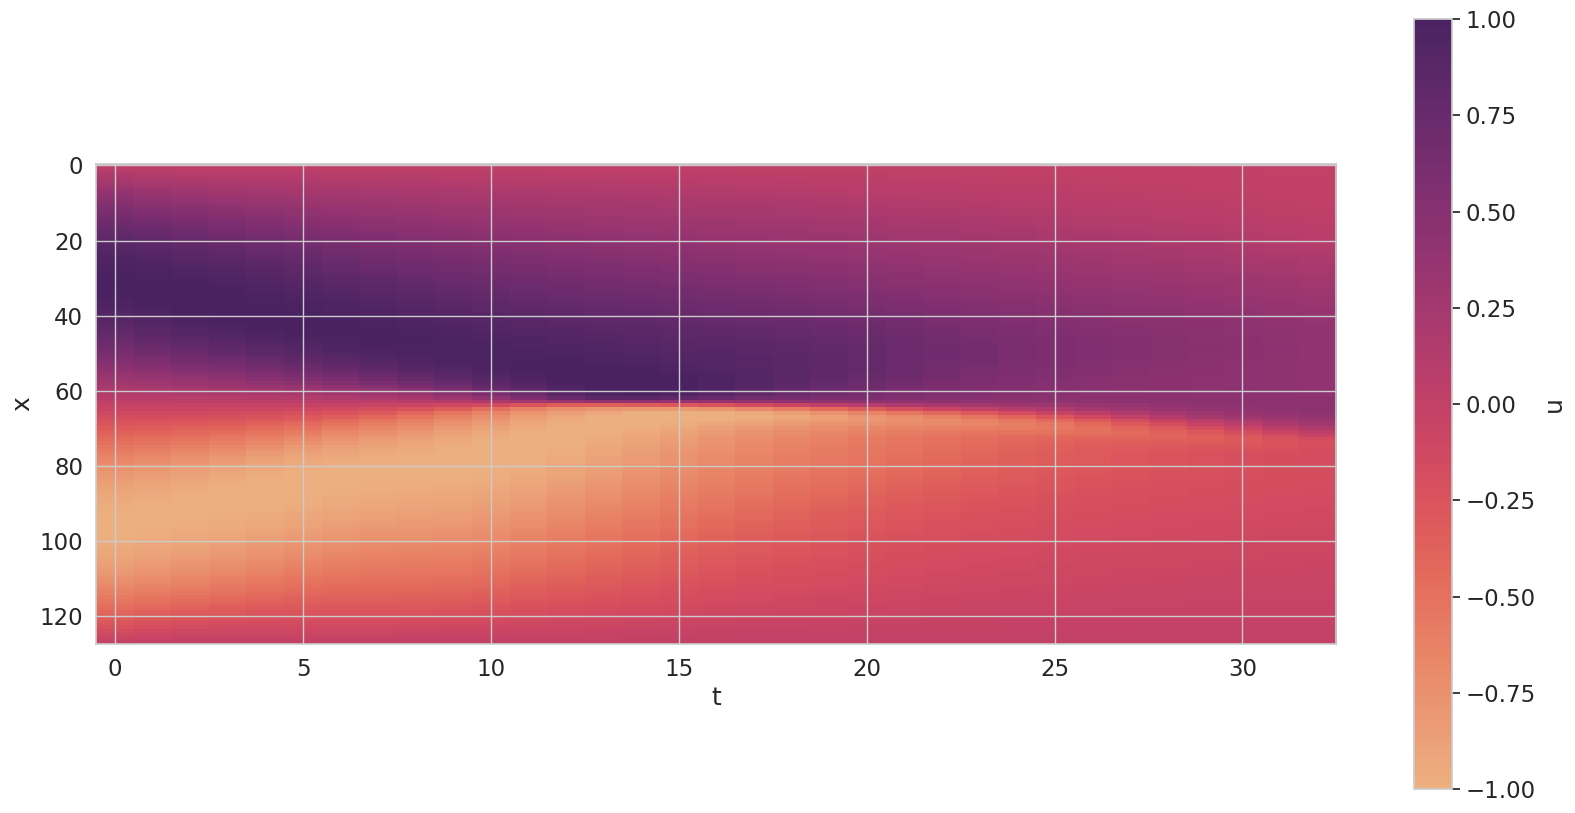

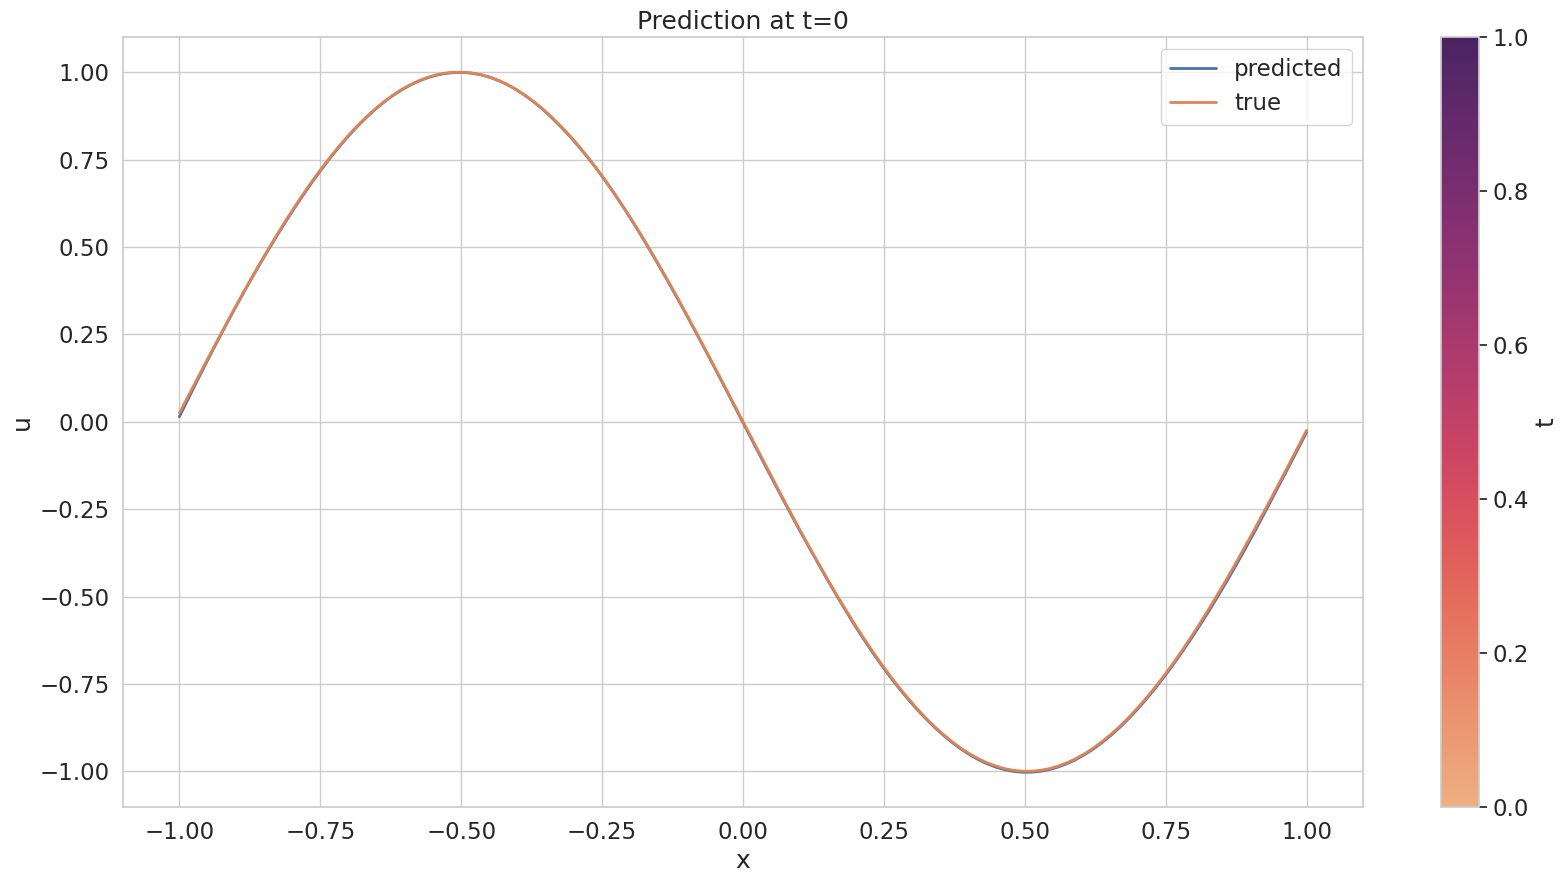

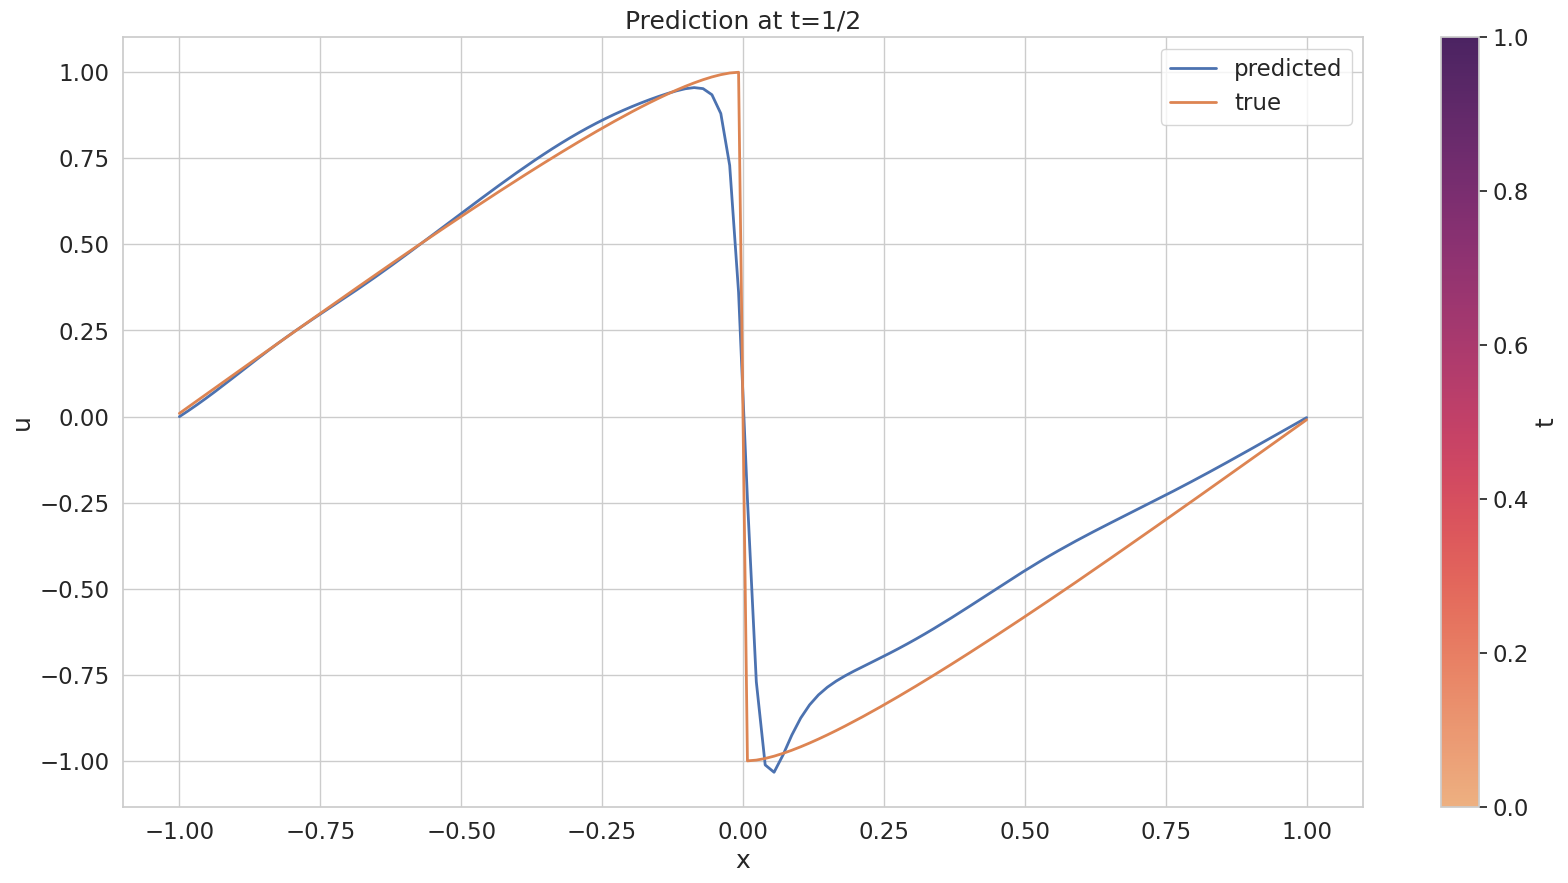

In [ ]:
eval_net(net, vels);

Let's implement physical loss

In [ ]:
def physical_loss_burgers(u: torch.Tensor, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the residual loss.

    Compute the residual using torch autograd, compute MSE of it.

    :param u: velocities tensor, scalar
    :param x: space tensor, shape (num_samples, 1)
    :param t: time tensor, shape (num_samples, 1)
    :returns: MSE of residual, scalar tensor
    """
    u_t = get_derivatives_torch(u, t)
    u_x = get_derivatives_torch(u, x)
    u_xx = get_derivatives_torch(u_x, x)
    resid = u_t + u * u_x - nu * u_xx
    return torch.mean(resid ** 2)

In [ ]:
def train_step_physical(
    model: BurgersNet,
    optimizer: Optimizer,
    loss_function: nn.Module,
    num_points: int,
    physical_loss: Callable,
    x_ph: torch.Tensor,
    t_ph: torch.Tensor,
) -> torch.Tensor:
    """Do one training epoch with physical loss.

    :param model: BurgersNet instance
    :param optimizer: optimizer
    :param loss_function: loss_function
    :param num_points: number of points for initial condition
    :param physical_loss: physical_loss
    :param x_ph: physical space points tensor, shape (num_physical_samples, 1)
    :param t_ph: physical time points tensor, shape (num_physical_samples, 1)
    :returns: train loss at this epoch
    """
    model.train()
    optimizer.zero_grad()

    x, t, u = ground_truth(num_points)
    uh = model(x, t)
    loss1 = loss_function(uh.squeeze(), u)

    uh_ph = model(x_ph, t_ph)
    loss2 = physical_loss(uh_ph.sum(), x_ph, t_ph)

    loss = loss1 + phy_coef * loss2
    loss_value = loss.item()

    loss.backward()
    optimizer.step()
    return loss_value

In [ ]:
epochs = 60000
num_points = 100
phy_num_points = 10
phy_coef = 1e-3

In [ ]:
x_ph = torch.rand(phy_num_points) * 2 - 1
x_ph.requires_grad_(True);
t_ph = torch.rand(phy_num_points)
t_ph.requires_grad_(True);

In [ ]:
net = BurgersNet(8, 32).float()
lossf = nn.MSELoss()
optim = Adam(net.parameters(), lr=1e-3)

**Warning**, takes some serious time:

In [ ]:
train_losses = []
for epoch in range(epochs):
    loss_value = train_step_physical(net, optim, lossf, num_points, physical_loss_burgers, x_ph, t_ph)
    train_losses.append(loss_value)
plot_learning_curve(train_losses)

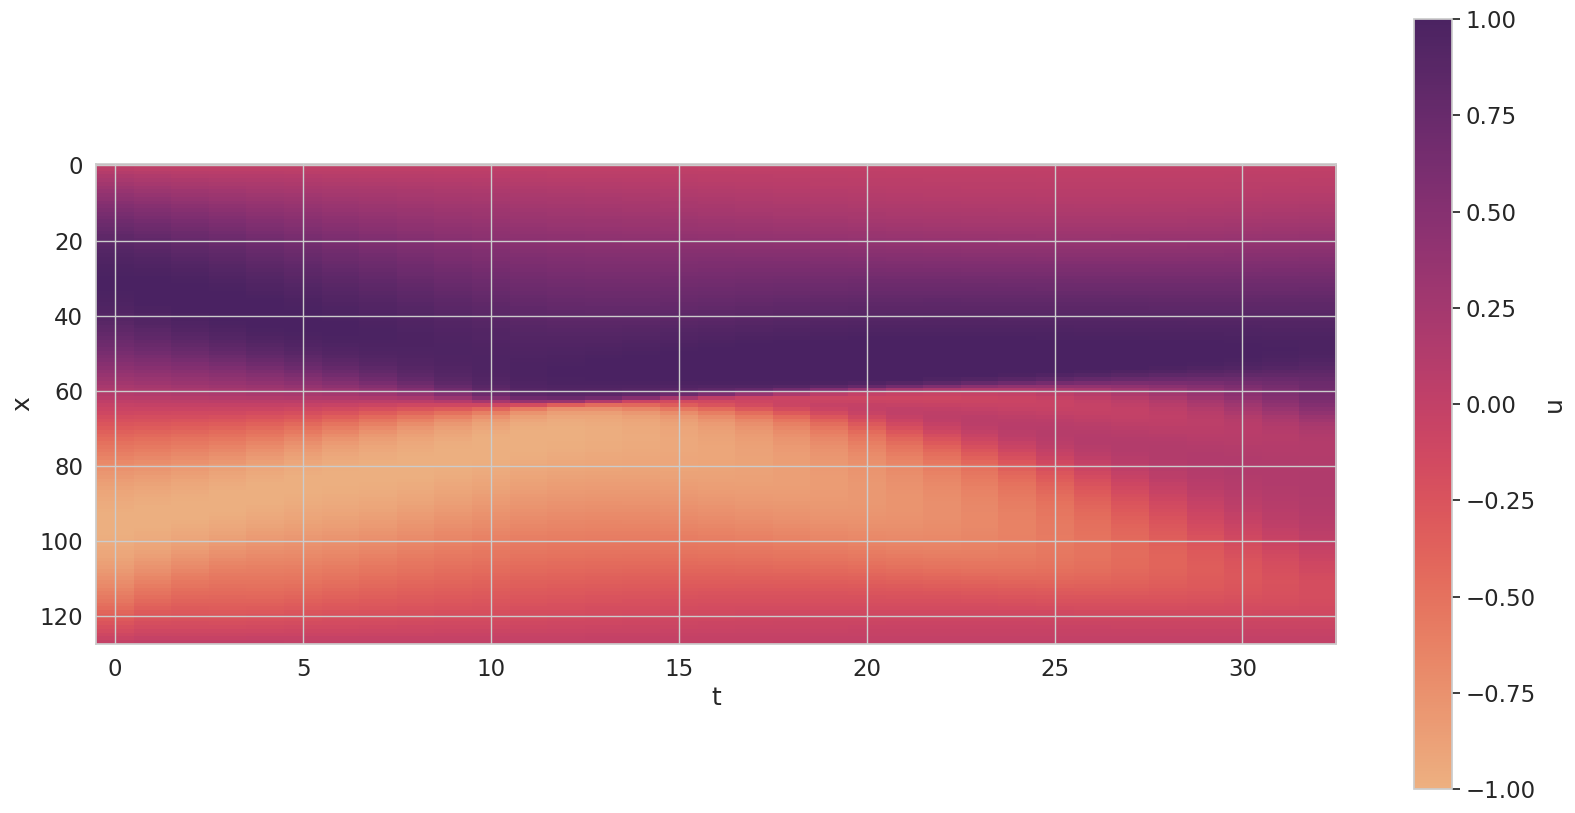

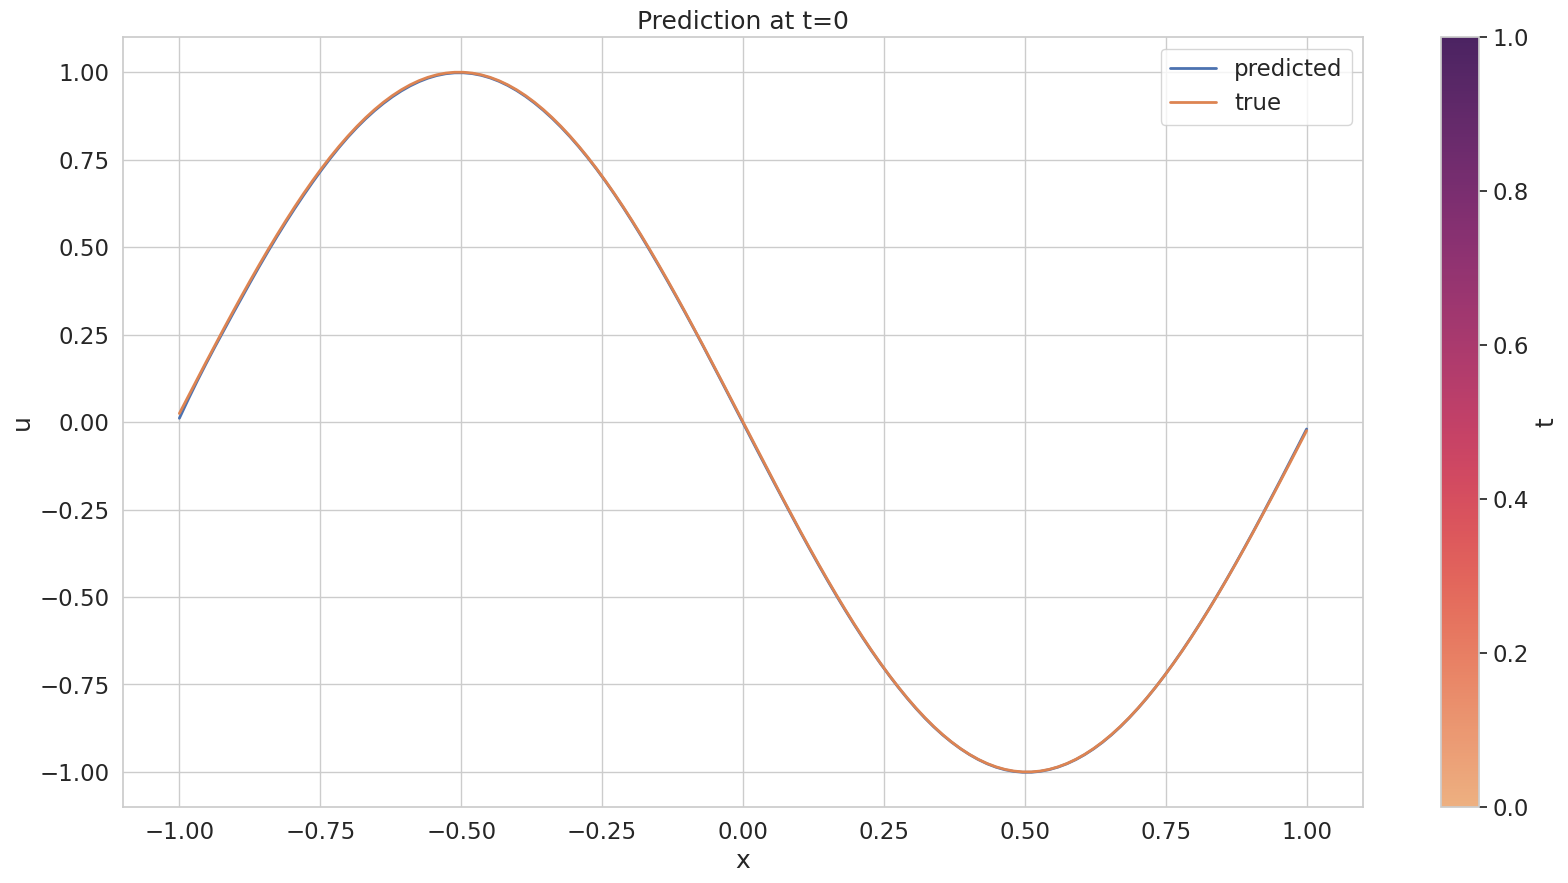

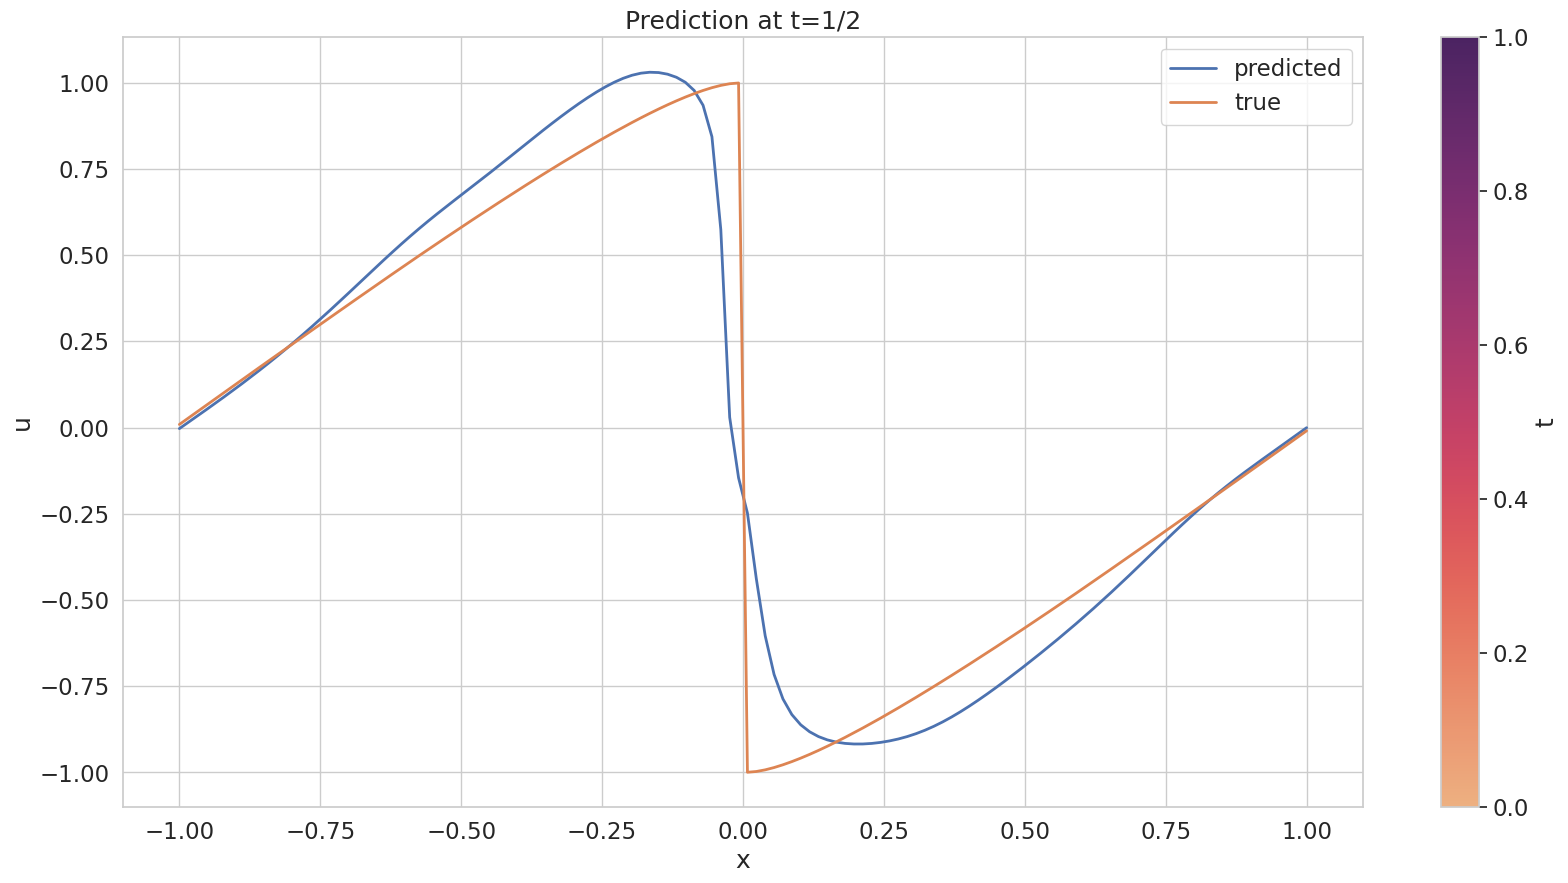

In [ ]:
eval_net(net, vels);

Important questions:
1. You may notice the dramatic change in epochs number. The reason is that most PIML losses make learning a much more difficult task, and sometimes learning may even fail. In the simple scenarios that we covered, this did not happen. If that happens, it is suggested to use scheduing for the value of `phy_coef`, gradually increasing it from zero to a pre-defined value.
2. You may also find (through excessive experimentation) that the number of points to evaluate physical constraints and their positions influences the learning greatly. The reason is quite simple: with more points to sample, the network tends to pick the simplest solution to an ODE or PDE, which is zeros.
3. So is PIML useless? No, of course not. However, it need some tweaking and getting a good result is more like a work of art.

For further improvements you may try different hints described in:\
Krishnapriyan, Aditi, et al. "Characterizing possible failure modes in physics-informed neural networks." NeurIPS (2021)